# Computación Bio-inspirada. Bloque II: Machine Learning. 
# 15 Multi-objective correlation-based feature selection con algoritmos evolutivos multi-objetivo (pymoo) 

Santiago Méndez García (s.mendezgarcia@um.es), Domingo Méndez García (domingo.mendezg@um.es)

Computación Bio-inspirada. Máster en Inteligencia Artificial. Universidad de Murcia. Curso 2024/2025.

## 1. Objetivos y metodología

Diseñar un MOEA como estrategia de búsqueda usando el enfoque multi-objetivo propuesto en el Tema
5, pág. 13. Implementarlo con representación binaria, cruce uniforme (𝑝𝑝𝑐𝑐 = 0.6), mutación bit-flip (𝑝𝑝𝑚𝑚 = 0.1) y
100000 evaluaciones de la función objetivo. Ejecutar el AE 10 veces con diferente
semilla para el conjunto de datos ALL-AML_train 5 . Visualizar gráficamente la
evolución del algoritmo (10 runs sobre el mismo gráfico). Reportar la siguiente tabla
de resultados:

| Seed | HV | ACC ALL-AML_train RF | ACC ALL-AML_train SVM | ACC ALL-AML_train MLP | ACC ALL-AML_test RF | ACC ALL-AML_test SVM | ACC ALL-AML_test MLP |
|------|---------|-----------------------|------------------------|------------------------|----------------------|-----------------------|-----------------------|
| 1    |         |                       |                        |                        |                      |                       |                       |
| 2    |         |                       |                        |                        |                      |                       |                       |
| ...  |         |                       |                        |                        |                      |                       |                       |
| 10   |         |                       |                        |                        |                      |                       |                       |
| Mejor   |     |                       |                        |                        |                      |                       |                       |
| Peor    |     |                       |                        |                        |                      |                       |                       |
| Promedio |   |                       |                        |                        |                      |                       |                       |
| Desv. Tip. |  |                       |                        |                        |                      |                       |                       |


Para RF, SVM y MLP usar sklearn.ensemble.RandomForestClassifier,
sklearn.svm.SVC y sklearn.neural_network, respectivamente con los hiperparámetros por defecto. Por otro lado, reportar la siguiente tabla:

| Todos los atributos |                        |                        |                        |                       |                       |                       |
|---------------------|------------------------|------------------------|------------------------|-----------------------|-----------------------|-----------------------|
| ACC ALL-AML_train RF | ACC ALL-AML_train SVM | ACC ALL-AML_train MLP | ACC ALL-AML_test RF | ACC ALL-AML_test SVM | ACC ALL-AML_test MLP |
|                      |                        |                        |                       |                       |                       |

En la primera tabla reportada, HV es el hipervolume y el
resto de los resultados se corresponderán con los de la mejor solución no-dominada
identificada por el MOEA. Consideramos la mejor solución no dominada como, para cada modelo de ML, la solución no dominada de la población obtenida por el MOEA que obtenga mejor métrica accuracy en validación.

### Requerimientos

A continuación se importan las librerías de _Python_ necesarias, se establece la semilla de _Numpy_ para la reproducibilidad y se definen la ruta del directorio donde se guardarán los resultados y algunas variables que se pueden utilizar para hacer pruebas de menor tamaño o utilizar los resultados ya guardados.

In [10]:
# === Bibliotecas estándar de Python ===
import os # crear y leer archivos
import sys
import time # tiempos de ejecución
import copy # copia profunda de objetos (callback pymoo)
import random
import pickle # guardar y cargar objetos
import warnings
import pkg_resources

# === Utilidades para notebooks ===
from IPython.display import display, HTML

# === Bibliotecas científicas ===
import numpy as np                           # Vectores y matrices
import pandas as pd                          # Dataframes
import matplotlib.pyplot as plt              # Gráficos
from scipy.io import arff                    # Lectura de archivos .arff (Weka)
from scipy.stats import pointbiserialr       # Correlación punto-biserial

# === Scikit-learn: ML y procesamiento ===
from sklearn.preprocessing import LabelEncoder            # Codificación de variables categóricas
from sklearn.impute import SimpleImputer                  # Imputación de valores faltantes
from sklearn.model_selection import (train_test_split,
                                     cross_val_score,
                                     StratifiedKFold,
                                     RepeatedStratifiedKFold)      # División y validación cruzada
from sklearn.exceptions import ConvergenceWarning          # Manejador de warnings
from sklearn.feature_selection import SelectKBest, f_classif # Selección de características por ranking

# == modelos para la práctica ==

from sklearn.ensemble import RandomForestClassifier        # Clasificador de Bosques Aleatorios
from sklearn.svm import SVC                                # Clasificador de Vectores de Soporte
from sklearn.neural_network import MLPClassifier           # Perceptrón multicapa

# == Test estadísticos ==
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
from scipy.stats import wilcoxon
from scipy.stats import shapiro

# === Pymoo: Optimización multiobjetivo evolutiva ===
import pymoo                                               # Framework de optimización multiobjetivo

# Algoritmos evolutivos
from pymoo.algorithms.moo.nsga2 import NSGA2               # Algoritmo NSGA-II

# Problemas y núcleo

from pymoo.core.problem import ElementwiseProblem          # Definición del problema multiobjetivo

# Terminación y optimización
from pymoo.optimize import minimize                        # Función principal de optimización
from pymoo.termination import get_termination              # Criterios de parada

# Visualización de resultados
from pymoo.util.plotting import plot
from pymoo.visualization.scatter import Scatter            # Dispersión de soluciones
from pymoo.visualization.pcp import PCP                    # Parallel Coordinate Plot

# Métricas de calidad
from pymoo.indicators.gd import GD                         # Generational Distance
from pymoo.indicators.gd_plus import GDPlus
from pymoo.indicators.igd import IGD                       # Inverted GD
from pymoo.indicators.igd_plus import IGDPlus
from pymoo.indicators.hv import HV                         # Hypervolume

# Operadores evolutivos
from pymoo.operators.crossover.ux import UniformCrossover  # Cruce uniforme (binario)
from pymoo.operators.mutation.bitflip import BitflipMutation  # Mutación bitflip
from pymoo.operators.sampling.rnd import (Sampling,
                                          BinaryRandomSampling)  # Muestreo aleatorio binario
from pymoo.operators.selection.tournament import TournamentSelection # Selección por torneo
from pymoo.algorithms.moo.nsga2 import binary_tournament # Selección por torneo binario

# Utilidades adicionales de pymoo
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting  # Ordenación por no dominación
from pymoo.core.callback import Callback                   # Callbacks para guardar resultados por generación
from pymoo.core.selection import Selection                 # Clase base para selección

from pymoo.util.display.output import Output, pareto_front_if_possible # Salida de resultados
from pymoo.util.display.multi import MultiObjectiveOutput




# === Warnings (desactivación de advertencias) ===
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter('ignore', category=ConvergenceWarning)
warnings.simplefilter("ignore", category=UserWarning)


profiling = False # Poner a True para hacer profiling
LEVEL = 2 # Tamaño de profiling (1: bajo, 2: medio, 3: alto)

DATASET_NAME = '../DATASETS/ALL-AML' # Atributos numéricos y categóricos
DATASET_TRAIN_PATH = DATASET_NAME + '_train.arff' # Ruta del archivo de entrenamiento
DATASET_TEST_PATH = DATASET_NAME + '_test.arff' # Ruta del archivo de prueba

RESULTS_DIR = 'cbio_p15_results' if not profiling else 'cbio_p15_results_profiling' # Directorio de resultados

DONE = False # Poner a True para ejecutar los algoritmos y entrenamientos
LOAD = DONE # Cargar resultados de pruebas anteriores
DEBUG = False # Poner a True para verbose

SEED = 2025
np.random.seed(SEED)   # Establecer semilla
random.seed(SEED) # Establecer semilla

In [11]:
# Reportar versiones de las librerías

# Obtenemos la versión de Python
version_python = sys.version

# Crear contenido HTML para mostrar en el notebook
html_content = f"""
<table>
    <tr><th>Python Version</th></tr>
    <tr><td>{version_python}</td></tr>
</table>
"""

# Mostrar la versión de Python en el notebook
display(HTML(html_content))

# Obtenemos la versión de las librerías

# Define la lista de librerías que deseas verificar
librerias_interes = [
"ipython",
"landscapes",
"matplotlib",
"numpy",
"pandas",
"scipy",
"sklearn",
"tqdm",
"pymoo",
"pyswarms",
]
# Crear una lista con las versiones de las librerías de interés
versiones = []
for lib in librerias_interes:
    try:
        version = pkg_resources.get_distribution(lib).version
        versiones.append((lib, version))
    except pkg_resources.DistributionNotFound:
        versiones.append((lib, "No instalada"))

# Generar una tabla en HTML para mostrar en el notebook
html_content = "<table>"
html_content += "<tr><th>Library</th><th>Version</th></tr>"
for package_name, version in versiones:
    html_content += f"<tr><td>{package_name}</td><td>{version}</td></tr>"
html_content += "</table>"

# Mostrar la tabla en el notebook
display(HTML(html_content))

### Cargar Dataset

In [12]:
def LoadData(file_path):

    data, meta = arff.loadarff(file_path)

    # Convertir a DataFrame
    df = pd.DataFrame(data)

    # Separar atributos numéricos y categóricos
    numeric_attributes = df.iloc[:, :-1] .select_dtypes(include=['int', 'float']).columns
    categorical_attributes =  df.iloc[:, :-1].select_dtypes(include=['object']).columns
    
    # Imputación para atributos numéricos
    if numeric_attributes.size>0:
        df[numeric_attributes] = SimpleImputer(strategy='mean').fit_transform(df[numeric_attributes])
        
    # Imputación para atributos categóricos
    # Aplicar hot encoding
    if categorical_attributes.size>0:
        df[categorical_attributes] = SimpleImputer(strategy='most_frequent').fit_transform(df[categorical_attributes])
        X = pd.get_dummies(data=df.iloc[:, :-1], columns=categorical_attributes)    
        X = X.astype(float)
    else:
        X = df.iloc[:, :-1]    
    
    # Salida: y
    y = [label.decode('utf-8') for label in df.iloc[:, -1]]
    class_values = meta[meta.names()[-1]][1]  # Obtiene los valores posibles de la clase 
    le = LabelEncoder() # para codificar la clase binaria
    le.fit(class_values)
    y = le.transform(y)
    y = y.astype(np.int32)

    return X,y

In [13]:
def summarize_arff(file_path):
    """
    Summarizes an ARFF dataset by providing the number of rows, features, 
    data types, and basic statistics for numerical features.
    
    Args:
        file_path (str): Path to the ARFF file.
    """
    # Load the ARFF file
    data, meta = arff.loadarff(file_path)
    
    # Convert to a Pandas DataFrame
    df = pd.DataFrame(data)
    
    # Display basic information
    print(f"Dataset Summary for: {file_path}")
    print(f"Number of rows: {df.shape[0]}")
    print(f"Number of features: {df.shape[1]}")
    print("\nFeature Types:")
    print(df.dtypes)
    
    # Separate numerical and categorical features
    numeric_features = df.select_dtypes(include=['int64', 'float64'])
    categorical_features = df.select_dtypes(include=['object'])
    
    # Count nans in all features
    nan_counts = df.isnull().sum().sum()
    print(f"\nNaN Counts:{nan_counts}")
    
    # Display unique values for categorical features
    if not categorical_features.empty:
        print("\nCategorical Features Unique Values:")
        for col in categorical_features.columns:
            print(f"{col}: {df[col].nunique()} unique values")

In [14]:
summarize_arff(DATASET_TRAIN_PATH)

Dataset Summary for: ../DATASETS/ALL-AML_train.arff
Number of rows: 38
Number of features: 7130

Feature Types:
attribute1       float64
attribute2       float64
attribute3       float64
attribute4       float64
attribute5       float64
                  ...   
attribute7126    float64
attribute7127    float64
attribute7128    float64
attribute7129    float64
myclass           object
Length: 7130, dtype: object

NaN Counts:0

Categorical Features Unique Values:
myclass: 2 unique values


El dataset de train, ALL-AML_train, tiene 38 filas y 7130 columnas, de las cuales 7129 son atributos predictores numéricos y 1 es el target, que es una etiqueta binaria.

In [15]:
X_train,y_train = LoadData(DATASET_TRAIN_PATH)
X_test,y_test = LoadData(DATASET_TEST_PATH)

K = 4 if not profiling else 2 # Número de pliegues para la validación cruzada
cv = RepeatedStratifiedKFold(n_splits=K, n_repeats=2, random_state=SEED)

Cargamos los datasets de train y test y generamos una partición de crosvalidación estratificada para la validación de los modelos de ML.

In [16]:
print(f"Test dataset shape: {X_test.shape}")

Test dataset shape: (34, 7129)


El dataset de test tiene 34 ejemplos.

In [17]:
n_features = X_train.shape[1]

print(f"Train dataset shape: {X_train.shape}")

Train dataset shape: (38, 7129)


In [18]:
# Number of target classes
n_classes = len(np.unique(y_train))
print(f"Number of classes: {n_classes}")

Number of classes: 2


### Análisis exploratorio: correlación entre atributos

El problema de selección de atributos basado en correlación utiliza la correlación entre atributos para calcular una medida de evaluación de subconjuntos de atributos. Conviene analizar tanto la correlación entre los atributos y el target como la correlación de los pares de atributos entre sí. Así podremos ver cómo es nuestra instancia del problema, en particular si hay muchos atributos relevantes o redundantes, y esto nos servirá para analizar los resultados obtenidos más tarde.

In [19]:
# Correlations between features and target
correlations = []
for i in range(n_features):
    corr, _ = pointbiserialr(X_train.iloc[:, i], y_train)
    correlations.append((i, abs(corr)))
correlations = sorted(correlations, key=lambda x: abs(x[1]), reverse=True)
print("Top 10 features by correlation with target:")
for i, corr in correlations[:10]:
    print(f"Feature {i}: {corr:.4f}")

Top 10 features by correlation with target:
Feature 3319: 0.8283
Feature 4846: 0.8223
Feature 2019: 0.8112
Feature 1744: 0.7768
Feature 5038: 0.7765
Feature 1833: 0.7707
Feature 460: 0.7578
Feature 4195: 0.7495
Feature 3846: 0.7471
Feature 2287: 0.7435


Analizamos la correlación entre las features predictoras y el objetivo. Aquí vemos el top 10 de features más correlacionadas con el objetivo, siendo la primera el atributo 3319 con una correlación absoluta de 0.8283. Los 10 tienen una correlación absoluta superior a 0.7.

In [20]:
# Correlation stats
df_corr_abs = pd.DataFrame(correlations, columns=['Feature', 'Abs Correlation'])
print("Estadísticas de la correlación absoluta:")
display(df_corr_abs['Abs Correlation'].describe())

print(f"{len(df_corr_abs[df_corr_abs['Abs Correlation'] > 0.5])/len(df_corr_abs)*100:.2f}% de los atributos tienen correlación absoluta > 0.5")


Estadísticas de la correlación absoluta:


count    7129.000000
mean        0.211047
std         0.149972
min         0.000066
25%         0.087310
50%         0.184025
75%         0.309132
max         0.828290
Name: Abs Correlation, dtype: float64

4.61% de los atributos tienen correlación absoluta > 0.5


La correlación absoluta media es bastante alta: 0.21, y el 4.61% de los atributos tienen una correlación absoluta superior a 0.5 con el target. Seleccionar los atributos con mayor correlación puede ser clave para conseguir un buen modelo con pocos atributos.

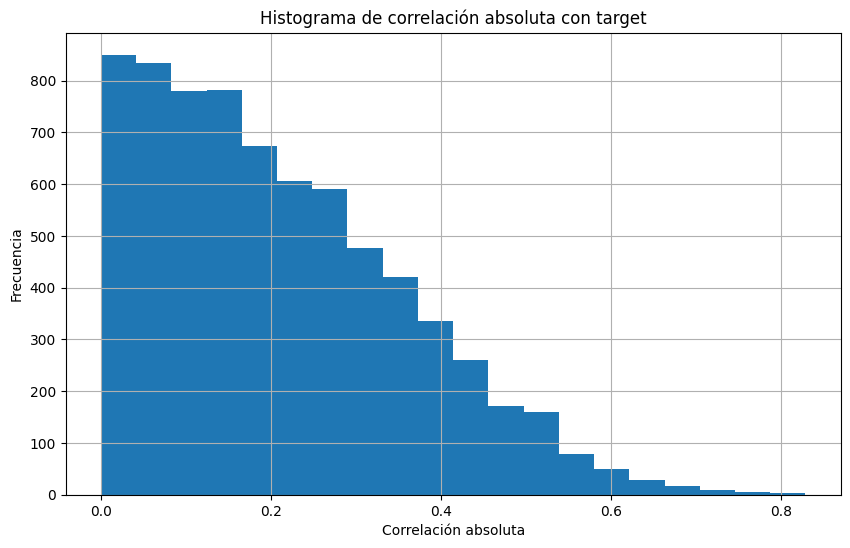

In [21]:
plt.figure(figsize=(10, 6))
plt.title("Histograma de correlación absoluta con target")
df_corr_abs['Abs Correlation'].hist(bins=20)
plt.xlabel("Correlación absoluta")
plt.ylabel("Frecuencia")
plt.show()

Vemos el histograma de correlación absoluta de las features con el target. Un 25% se sitúan por encima de 0.2.

Ahora analizamos la correlación entre los atributos.

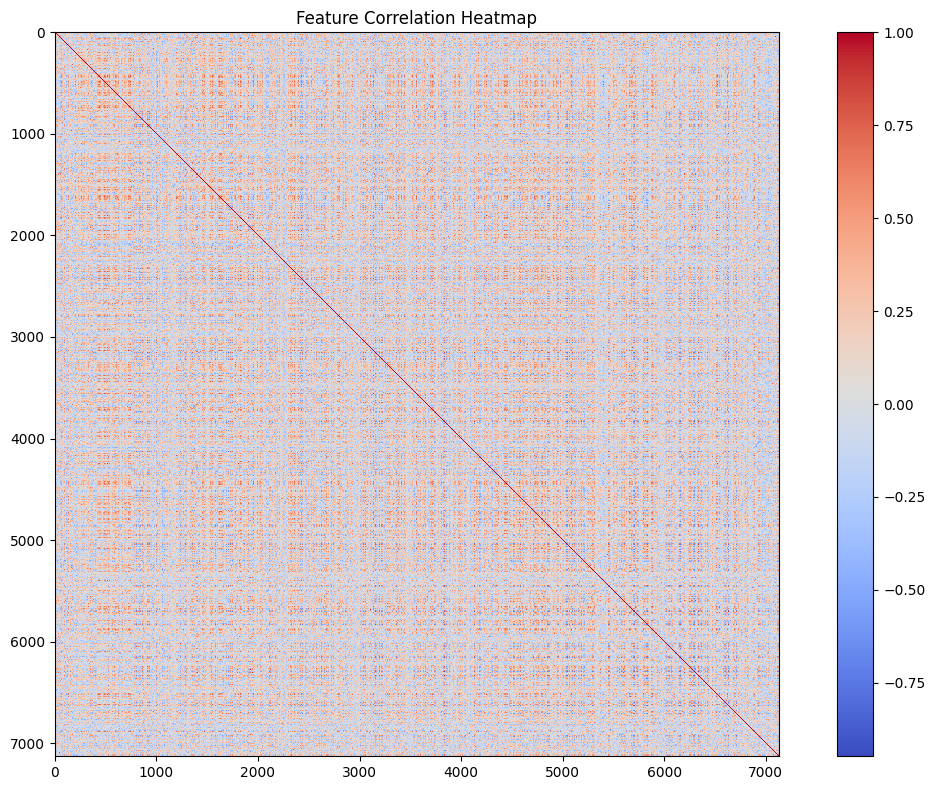

In [22]:
# Correlation heatmap
Xy_train = pd.concat([X_train, pd.Series(y_train)], axis=1)

plt.figure(figsize=(12, 8))
plt.title("Feature Correlation Heatmap")
plt.imshow(Xy_train.corr(), cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.tight_layout()
plt.show()

Hay tantos atributos que el heatmap no es interpretable, hay una variedad de correlaciones positivas y negativas entre atributos pero dado el tamaño del dataset no podemos cuantificarlas así. Veamos un resumen estadístico de estas correlaciones.

In [23]:
# Obtener 10 máximas correlaciones entre features en X_train

def get_top_correlations(X, n=10):
    """
    Get the top n correlations between features in a DataFrame.
    
    Args:
        X (pd.DataFrame): DataFrame containing features.
        n (int): Number of top correlations to return.
        
    Returns:
        pd.DataFrame: DataFrame with top n correlations.
    """
    corr_matrix = X.corr().abs()
    corr_matrix.values[np.tril_indices_from(corr_matrix, k=0)] = 0  # Set lower triangle to 0 to ignore duplicates
    
    corr_pairs = corr_matrix.unstack().sort_values(ascending=False)
    top_corr = corr_pairs[corr_pairs < 1].head(n)
    
    return top_corr, corr_matrix

top_correlations_df, corr_matrix = get_top_correlations(X_train, n=10)
print("Top 10 feature correlations:")
display(top_correlations_df)

Top 10 feature correlations:


attribute5987  attribute5986    0.994882
attribute6183  attribute6182    0.994788
attribute6088  attribute5449    0.992730
attribute6803  attribute6797    0.991816
attribute6806  attribute6803    0.989830
attribute6201  attribute6200    0.989570
attribute7093  attribute7066    0.988301
attribute5071  attribute990     0.985045
attribute5599  attribute5376    0.984873
attribute6806  attribute6797    0.982710
dtype: float64

En el top 10 de correlaciones absolutas de atributos todas son superiores al 98%. Hay columnas redundantes en el dataset, que seguramente convendrá filtrar en la selección de atributos porque no aportarán nueva información al modelo.

In [24]:
# Summarize the correlation matrix
def summarize_correlation_matrix(corr_matrix):
    """
    Summarizes the correlation matrix by providing mean, std, min, and max values.
    
    Args:
        corr_matrix (pd.DataFrame): Correlation matrix.
        
    Returns:
        dict: Summary statistics of the correlation matrix.
    """
    # Select upper triangle of the correlation matrix
    upper_triangle = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    feature_corr_vals = pd.DataFrame(corr_matrix.values[upper_triangle], columns=['Correlation'])
    display(feature_corr_vals.describe())
    return feature_corr_vals

print("Feature correlation matrix summary:")
feature_corr_vals = summarize_correlation_matrix(corr_matrix)

Feature correlation matrix summary:


Correlation
count  2.540776e+07
mean   1.905240e-01
std    1.457169e-01
min    0.000000e+00
25%    7.495071e-02
50%    1.591899e-01
75%    2.743225e-01
max    9.948823e-01

Arriba imprimimos un resumen estadístico de los valores de correlación absoluta de los pares de atributos distintos. La correlación absoluta media es casi 0.2. Hay una gran parte de atributos con muy baja correlación, el 25% de los pares tienen menos de 0.075. El 25% tienen más de 0.274. La redundancia no es despreciable y antes hemos visto una alta relevancia de buena cantidad de atributos, así que esperamos que los subconjuntos de atributos seleccionados obtenidos puedan ser a la vez pequeños y con alto score de correlación.

## 2. Problema del Multi-objective correlation-based feature selection 

El problema de la selección de atributos (SA), o *feature selection*, en Machine Learning (ML) se trata de, dado un dataset, seleccionar el subconjunto de atributos mínimo más "relevante" o "útil" para la tarea de predicción. Las principales razonas para aplicar SA son reducir el tiempo de entrenamiento y/o la complejidad del modelo, evitando overfitting y facilitando la interpretabilidad, incluso en ocasiones mejorando la precisión del modelo. Dependiendo del enfoque utilizado, la relevancia o utilidad del subconjunto de atributos puede medirse de distintas formas, dando lugar a distintos tipos de SA. Los problemas de SA se pueden clasificar principalmente en:

-  **Evaluación de atributos** o feature ranking: evalúan los atributos individualmente.
-  **Evaluación de subconjuntos de atributos**: evalúan subconjuntos sucesivos de atributos generados por una estrategia de búsqueda.

Los métodos de SA están íntimamente ligados con el tipo de problema, y se pueden clasificar en:

-  **Wrapper**: la función objetivo es el rendimiento del modelo de ML, con la métrica de evaluación adecuada sobre un conjunto de validación. En clasificación puede usarse el accuracy.
-  **Integrado**: modelos que realizan la selección de atributos como parte del proceso de entrenamiento. Por ejemplo, árboles de decisión o regresión Lasso.
-  **Filtro**: separa la selección de atributos del algoritmo de aprendizaje. El subconjunto de atributos se escoge optimizando alguna medida estadística de información.

En nuestro caso la tarea de predicción es la clasificación binaria, y el dataset tiene un gran número de atributos (7138) que la SA pretende reducir. Consideraremos la SA como un problema de evaluación de subconjuntos de atributos y lo resolveremos con un métodos filtro (seleccionar antes de entrenar). Vamos a considerar el problema de la evaluación de subconjuntos de atributos como un problema de optimización combinatoria booleana multiobjetivo: por un lado, queremos minimizar el número de atributos seleccionados; por otro, queremos maximizar una métrica de correlación entre los atributos seleccionados y el target. Para resolverlo usaremos un algoritmo evolutivo multiobjetivo (MOEA) como estrategia de búsqueda, en concreto, será NSGA-II.

A continuación, describimos la formulación del problema de optimización multiobjetivo que representa la selección de atributos.

Sea $m = 7129$ el número de atributos de nuestro dataset. Las variables de decisión del problema son $x_l \in \{0,1\}, l= 1, \ldots, m$, que representan la selección o no de los atributos, de la siguiente forma:

$$ \forall l = 1, 2, \ldots, m, \qquad x_l = 
\begin{cases} 
1 & \text{si el atributo } l \text{ es seleccionado}, \\
0 & \text{si el atributo } l \text{ no es seleccionado}.
\end{cases}$$

Antes de la exposición habíamos considerado el primer objetivo como el correlation-based feature selection merit score (Hall, 1999), que es una medida de compromiso entre la relevancia y la redundancia de los atributos seleccionados. Se define como:

$$\operatorname{Maximizar} f_2(x) =
\frac{\mathcal{C}(x) \cdot \sigma_{D}^{C}(x)}
{\sqrt{\mathcal{C}(x)+\mathcal{C}(x)\cdot(\mathcal{C}(x)-1)\cdot \sigma_{D}^{f}(x)}},$$

donde:
- $x = (x_1, x_2, \ldots, x_m)$ es el vector de variables de decisión.
- $\mathcal{C}(x) = \sum_{l=1}^m x_l$ es la cardinalidad del subconjunto de atributos seleccionados.
- $D$ es el dataset con $m$ atributos de entrada.
- $\sigma_{D}^{C}(x)$ es la correlación absoluta promedio entre cada atributo seleccionado en $x$ y el target.
- $\sigma_{D}^{f}(x)$ es la correlación absoluta promedio entre cada par de atributos seleccionados en $x$, de los $\binom{\mathcal{C}(x)}{2}$ posibles.

El numerador indica la capacidad predictiva (relevancia) del subconjunto de atributos seleccionados, mientras que el denominador indica la redundancia entre esos atributos. Sin embargo ese no es el enfoque planteado en el enunciado, y lo hemos cambiado.

El primer objetivo es maximizar la correlación absoluta media entre los atributos seleccionados y el target, es decir, siguiendo la notación anterior:

$$\operatorname{Maximizar} f_1(x) = \sigma_{D}^{C}(x) = \frac{1}{\mathcal{C}(x)} \sum_{l=1}^m x_l \cdot \sigma_{D,l}^{C},$$

donde $\sigma:{D,l}^{C}$ es la correlación absoluta entre el atributo $l$ y el target. La correlación la podemos calcular como la biserial-pointwise correlation, puesto que el target es binario. Este primer objetivo es una medida de relevancia del conjunto de atributos seleccionado. Observamos que el rango de $f_1$ es $[0,1]$, porque la correlación de Pearson, en valor absoluto, está en ese rango y estamos sacando la media.

El segundo objetivo es minimizar la correlación entre atributos, es decir:

$$\operatorname{Minimizar} f_2(x) = \sigma_{D}^{f}(x) = \frac{1}{\binom{\mathcal{C}(x)}{2}} \sum_{l=1}^m \sum_{k=1}^m x_l \cdot x_k \cdot \sigma_{D, l, k}^{f},$$

donde $\sigma_{D, l, k}^{f}$ es la correlación de Pearson entre los atributos $l$ y $k$, en valor absoluto. Este segundo objetivo es una medida de redundancia del conjunto de atributos seleccionado.

El tercer objetivo es minimizar el número de atributos seleccionados. En nuestro hemos utilizado la proporción de atributos seleccionados respecto al total de atributos para normalizarla entre 0 y 1:

$$\operatorname{Minimizar} f_3(x) = \frac{1}{m} \sum_{l=1}^m x_l.$$


Además, en nuestra implementación hemos añadido la siguiente restricción:

$$s. t. \qquad \mathcal{C}(x) \geq 2$$

ya que si una solución no selecciona al menos 1 atributo, no se puede construir el modelo clasificador, y si no selecciona al menos 2 no se puede calcular $f_2$.

Observamos que el rango de las funciones objetivo es:

$$ f_i(x) \in [0, 1] \forall i \in \{1,2,3\}.$$

Además, podemos expresar los objetivos $f_1$ y $f_2$ en forma matricial, permitiendo un cálculo más eficiente. Se define la matriz de correlación absoluta feature-target como: 

$$ \mathbf{F} = \begin{pmatrix}
F_1, F_2, \ldots, F_m \\
\end{pmatrix} \in \mathbb{R}^{1 \times m},$$

con $F_l = \sigma_{D,l}^{C}, \forall l \in \{1,2,\ldots, m\}$, y la matriz de correlación absoluta feature-feature como:

$$ \mathbf{G} = (G_{i,j})_{m \times m} ,$$

donde $G_{i,j} = \sigma_{D,i,j}^{f}, \forall i \neq j \in \{1,2,\ldots, m\}$ y $G_{i,i} = 0 \forall i \in \{1,2,\ldots,m\}$. Entonces, podemos expresar los objetivos como:

$$ f_1(x) = \frac{1}{\mathcal{C}(x)} \cdot \mathbf{F} \cdot x^T,$$
$$ f_2(x) = \frac{1}{\mathcal{C}(x)(\mathcal{C}(x)-1)} \cdot x^T \cdot \mathbf{G} \cdot x.$$

Observamos también que los dos primeros objetivos tienen denominador creciente en función de la cardinalidad del subconjunto de atributos seleccionados: todos los objetivos empujan a la minimización de la cardinalidad del subconjunto de atributos seleccionados. Esto nos servirá para explicar los resultados, como veremos más adelante.

## 3. Algoritmo evolutivo multiobjetivo (pymoo)

En esta sección detallamos el diseño de los componentes del algoritmo evolutivo multiobjetivo (MOEA) aplicado al problema de selección de atributos y su implementación mediante la librería *pymoo*.

La librería *pymoo* es una librería de Python para la optimización multiobjetivo y permite implementar algoritmos MOEA y personalizarlos con distintos operadores de selección, cruce, mutación y muestreo inicial. En este caso hemos implementado el algoritmo **NSGA-II** (Nondominated sortid Genetic Algorithm) con los siguientes componentes:

* **Representación**: la representación de las soluciones es binaria. Cada bit representa la selección o no de un atributo como hemos explicado en la sección anterior. La longitud del cromosoma es igual al número de atributos del dataset, $m = 7129$.
* **N=50**: tamaño de la población.
* **G=2000**: número de generaciones. En total se realizarán $N \cdot G = 50 \cdot 2000 = 100000$ evaluaciones de la función objetivo.
* **Selección**: usamos selección por torneo binario como es habitual en NSGA-II.

Antes de la presentación se utiliza la selección por ranking exponencial con $c = 0.3$. Al ser un problema multiobjetivo, no podemos ordenar la población por un único valor de fitness, así que habíamos decidido ordenar el ranking primero por no dominancia, y después dentro de cada frente de dominación ordenar decrecientemente por la distancia de crowding. La distancia de crowding mide cómo de cercano es un individuo a sus vecinos del mismo frente, así que al seleccionar los que tienen mayor distancia con sus vecinos intentábamos favorecer la diversidad de la población. También se usaba muestreo estocástico con reemplazo. En cada generación se seleccionan $N$ individuos de la población para formar la nueva población. Algunos individuos pueden ser seleccionados más de una vez y otros no ser seleccionados. La probabilidad de selección la da el ranking exponencial.

* **Cruce**: se utiliza el cruce uniforme con probabilidad $p_c = 0.6$. El cruce uniforme consiste en generar cada bit del hijo de forma independiente, con probabilidad $p_c$ de que el bit del padre 1 se copie al hijo y $1-p_c$ de que se copie el bit del padre 2.
* **Mutación**: se utiliza la mutación bit-flip con probabilidad $p_m = \frac{50}{m}$: cada bit del hijo tiene probabilidad $p_m$ de ser mutado, es decir, de cambiar su valor de 0 a 1 o de 1 a 0. En el enunciado se usaba $p_m = 0.1$, pero como el número de atributos es muy grande ($m = 7129$), esto causaba que en el peor caso de media se cambiaran más de 700 variables en cada individuo, lo que hace que los individuos mutados sean muy diferentes a sus originales y además que representen subconjuntos de atributos demasiado grandes. Por eso lo hemos cambiado por una probabilidad de mutación mucho más baja que esperamos que funcionara mejor. Así, con una probabilidad más baja los individuos mutados son más similares a los originales, o lo que es lo mismo, la estrategia de búsqueda actúa más localmente.
* **Sustitución generacional completa**. Se generan $N$ hijos en cada generación.
* **Elitismo**: por defecto en *pymoo* los mejores individuos de la población se mantienen en la siguiente generación.
* **Eliminación de duplicados**: se eliminan los individuos duplicados de la población, para evitar que haya dos individuos iguales en la población y favorecer la diversidad. Esto es común en NSGA-II.

La documentación de *pymoo* sobre NSGA-II está disponible en https://pymoo.org/algorithms/moo/nsga2.html

### Constantes del algoritmo evolutivo
- $N = pop\_size$: 50 Tamaño de la población
- $G = n\_gen = 2000$: Número de generaciones
- $seed$: Semilla para reproducibilidad

In [25]:
N_EVALUATIONS = 100000

pop_size = 50 if not profiling else 12*LEVEL
n_gen =  N_EVALUATIONS//pop_size if not profiling else 12*LEVEL
seed = SEED

### Definición del problema de optimización multi-objetivo

Implementamos el problema de selección de atributos multiobjetivo basado en correlación. Previamente, definimos dos funciones para calcular las correlaciones:

1. ***getTargetCorrelations***: calcula la correlación absoluta entre cada atributo y el target, devolviendo un vector de tamaño $m$.
2. ***getFeatureCorrelations***: calcula la correlación absoluta entre cada par de atributos, devolviendo una matriz de tamaño $m \times m$. Con la opción *triu=True* se devuelve la parte triangular superior de la matriz, para eliminar los pares de atributos repetidos y la diagonal.

In [26]:
NAN_CONST = 0
def getTargetCorrelations(X, y):
    """
    Calcula las correlaciones entre los atributos y la variable objetivo.
    """
    correlations = np.zeros(X.shape[1])
    for i in range(X.shape[1]):
        corr, _ = pointbiserialr(X[:, i], y)
        correlations[i] = abs(corr) # Feature selection: only magnitude matters
    correlations = np.nan_to_num(correlations, nan=NAN_CONST, posinf=NAN_CONST, neginf=NAN_CONST)  # Reemplazar NaN con 0
    return correlations

def getFeatureCorrelations(X, triu = False):
    """
    Calcula las correlaciones entre los atributos.
    """
    x_corr = np.abs(np.corrcoef(X, rowvar=False))
    
    # Tratar NaNs generados cuando un atributo es constante
    x_corr = np.nan_to_num(x_corr, nan=NAN_CONST, posinf=NAN_CONST, neginf=NAN_CONST)  # Reemplazar NaN con 0

    # Poner diagonal a 0
    np.fill_diagonal(x_corr, 0)
    if triu:
        # Poner la parte inferior de la matriz a 0
        # (caso simétrico)
        x_corr = np.triu(x_corr, k=1)
    
    return x_corr

In [27]:
x_corr = getFeatureCorrelations(X_train.values, triu=True)
# print nans
nans = np.isnan(x_corr)
print(f"NaNs in feature correlation matrix: {np.sum(nans)}")
print(f"Negs in feature correlation matrix: {np.sum(x_corr < 0)}")
y_corr = getTargetCorrelations(X_train.values, y_train)
# print nans
nans = np.isnan(y_corr)
print(f"NaNs in target correlation vector: {np.sum(nans)}")
print(f"Negs in feature correlation matrix: {np.sum(y_corr < 0)}")

print(x_corr[:10, :10])

NaNs in feature correlation matrix: 0
Negs in feature correlation matrix: 0
NaNs in target correlation vector: 0
Negs in feature correlation matrix: 0
[[0.         0.40448512 0.12584021 0.10626817 0.29272796 0.31272006
  0.11211397 0.13044582 0.08051244 0.20903199]
 [0.         0.         0.11154144 0.21154333 0.21357687 0.22110001
  0.14846236 0.06258055 0.25153082 0.0732407 ]
 [0.         0.         0.         0.13236261 0.12305274 0.10311344
  0.19020024 0.01562163 0.29182309 0.2293609 ]
 [0.         0.         0.         0.         0.10989979 0.14732549
  0.04221893 0.12335712 0.01726106 0.30985726]
 [0.         0.         0.         0.         0.         0.74370567
  0.17381198 0.59140091 0.38041424 0.12712836]
 [0.         0.         0.         0.         0.         0.
  0.00988818 0.66882474 0.31445118 0.13890302]
 [0.         0.         0.         0.         0.         0.
  0.         0.05359021 0.05697414 0.2666612 ]
 [0.         0.         0.         0.         0.         0.


Hemos implementado el problema de selección de atributos multiobjetivo basado en correlación, descrito en la sección 2, como una clase que hereda de la clase *ElementwiseProblem* de *pymoo*. Esta clase debe redefinir los siguientes métodos:

* ***__init__***: inicializa el problema, con 2 objetivos, $m$ variables de decisión binarias y 1 restricción. Además se pasa como parámetro el dataset etiquetado **(X,y)**, con el que calculamos las matrices de correlación (*getTargetCorrelations* y *getFeatureCorrelations*) para calcular *f2* posteriormente.
* ***_evaluate***: evalúa la función objetivo y la restricción para un individuo $x$. La función objetivo es un vector $(f_1, f_2, f_3)$. La restricción $\sum_{l=1}^{m}{x_l} \geq 2$ se guarda con un valor $g$ que es menor o igual que 0 si y solo si se cumple la restricción. Vamos a implementar el problema como una minimización, así que hemos cambiado el signo a $f_1$ respecto a lo explicado en la sección 2. Ahora tenemos que $f_1(x) = -1 \times { \sigma_{D}^{C}(x)}$
* ***_calc_pareto_front***: calcula el frente de Pareto para el problema. En este caso el frente de Pareto no es conocido, así que la función devuelve los valores $(f_1,f_2, f_3)$ para una población ideal, que dominan a cualquier población que podamos obtener. Los valores los hemos calculado como $\{(0,0,0)\} \cup \{(f_1 = -1, f_2 = 0, f_3 = \frac{k}{m}): k = 1, \ldots, m\}$, que son los valores mínimos de $f_1$ y $f_2$ para cada valor posible de $f_3$.
* ***merit_score***: mérito correlation-based feature score de Hall (1999), que ya no se utiliza para el problema.

In [28]:
class FeatureSelection(ElementwiseProblem):

    def __init__(self, n_features : int, X : np.ndarray, y: np.ndarray, n_ieq_constr: int = 1):
        """
        Args:
            n_features (int): number of features in the dataset
            y_corr (np.ndarray): array of shape (n_features,) with the correlation of each feature with the target variable
            x_corr (np.ndarray): matrix of shape (n_features, n_features) with the correlation between features
        """
        super().__init__(n_var=n_features, n_obj=3, xl=0, xu=1, vtype=bool, n_ieq_constr=n_ieq_constr) # 0<=x<=1
        self.n_features = n_features
        
        self.X = X
        self.y = y
        
        x_corr = getFeatureCorrelations(X, triu=True)
        self.x_corr = x_corr
        self.y_corr = getTargetCorrelations(X, y)
        
        self.n_ieq_constr = n_ieq_constr

    def f1(self, x, c):
        """
        Objective function 1: maximize feature-target abs mean correlation
        Args:
            x (np.ndarray): array of shape (n_features,) with the selected features
            c (int): number of selected features
        """
        if c <= 0:
            return 0.0
        
        mean_y_corr = (self.y_corr @ x.T) / c
        return mean_y_corr
        
    
    def f2(self,x,c):
        """
        Objective function 2: minimize the feature-feature abs mean correlation.
        Args:
            x (np.ndarray): array of shape (n_features,) with the selected features
            c (int): number of selected features
        """
        if c < 2:
            return 0.0
        
        mean_x_corr = 2*(x @ self.x_corr @ x.T) / (c*(c-1))
        return mean_x_corr
    
    def f3(self, x):
        return np.sum(x)/self.n_features  # Minimize the number of selected features
    
    def merit_score(self, x, c):
        """
        Hall merit score
        """
        if c < 2:
            return 0.0
        
        mean_y_corr = (self.y_corr @ x.T) #/c # eliminar calculo duplicado
        mean_x_corr = 2*(x @ self.x_corr @ x.T) #/ (c*(c-1)) #eliminar calculo duplicado
        
        f2 = mean_y_corr / np.sqrt(c + mean_x_corr) 
        # c*mean_y_corr y c*(c-1)*mean_x_corr son calculos duplicados
        return f2
    

    
    def _evaluate(self, x, out, *args, **kwargs):
        # Correlation-based feature selection score
        
        c = np.sum(x)
        if self.n_ieq_constr > 0:
            out["G"] = np.array([2-c])  # Constraint: at least 2 features selected
        
        
        f1 = -1*self.f1(x, c) # Maximize the mean abs correlation with the target variable
        f2 = self.f2(x, c) # Minimize the mean abs correlation between features
        f3 = c/self.n_features # Minimize the portion of selected features

        out["F"] = np.column_stack([f1, f2, f3])
    
    def _calc_pareto_front(self): # para generar la población ideal (frente de Pareto real desconocido en este problema)
        n_pareto_points = self.n_features+1
        pf = np.ones((n_pareto_points,3))
        for i in range(n_pareto_points):
            pf[i][2] = i/self.n_features
            pf[i][0] = -1
            pf[i][1] = 0
        pf[0][0] = 0.0
        return pf

In [29]:
problem = FeatureSelection(n_features=n_features, X=X_train.to_numpy(),y=y_train)

Establecemos nuestra instancia del problema con los datos de ALL-AML_train.

### Visualización de puntos

In [30]:
def VisualizacionPuntos(title,values):
    if (len(values[0])>3):
        scatter = PCP()
    else:
        scatter = Scatter(angle=(45, 45), title=title)
    scatter.add(values)
    scatter.show()
    plt.title(title,pad=20)
    plt.grid(True)
    plt.show()

Esta función auxiliar grafica los puntos de la población en el espacio 3D de objetivos.

### Frente de Pareto (población ideal) para el cálculo de los indicadores de rendimiento
El frente de Pareto real es desconocido en este problema, se usa por tanto una población ideal como hemos explicado.

Número de puntos de la población ideal  ../DATASETS/ALL-AML_train.arff  : 7130


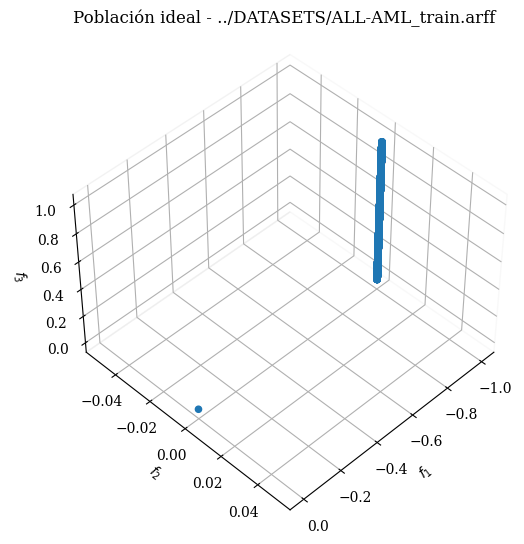

In [31]:
pf = problem.pareto_front()
print("Número de puntos de la población ideal ",DATASET_TRAIN_PATH," :",len(pf))    

title = "Población ideal - "+DATASET_TRAIN_PATH
VisualizacionPuntos(title,pf)

### Parámetros del algoritmo evolutivo

Hemos usado los siguientes parámetros para el algoritmo evolutivo NSGA-II:

- $G = 200$: Número de generaciones.
- $N = 50$: Tamaño de la población. En total $N \cdot G = 50 \cdot 200 = 10000$ evaluaciones de la función objetivo.
- $random\_state$: Semilla para reproducibilidad, que cambiaremos en cada prueba.
- $prob$: Probabilidades
- **Selección por torneo binario**.
- **Cruce uniforme** con probabilidad $p_c = 0.6$.
- **Mutación bit-flip** con probabilidad $p_m = \frac{50}{m}$.
- **Sustitución generacional completa**. Se generan $N$ hijos en cada generación.
- **Elitismo**: cada generación la forman los $N$ mejores individuos entre la población y los hijos generados.
- **Eliminación de duplicados**.

A continuación se implementa esta configuración y describiremos cómo se ha conseguido.

In [32]:
N = pop_size
G = n_gen

random_state = SEED

p_c = 0.6 # Probabilidad de cruce

p_m = 50/n_features # Probabilidad de mutación

print("p_m: ",p_m)

EPS = 1e-7

amin = 0    # linear ranking
amax = 2-amin # linear ranking
q = 0.7 # non linear ranking
c = 0.3 # exponential ranking
rank_type = 'exponential'

param = amin,amax,q,c,rank_type

p_m:  0.0070136063964090336


In [33]:
class Individuo:
    def __init__(self,n):
        self.x = np.zeros(n, dtype=bool)
        self.f2 = 0.0 # correlation-based score
        self.f1 = 1.0 # portion of selected features
    def __lt__(self, ind):
        # Orden lexicográfico
        if self.f1 < ind.f1:
            return True
        elif self.f1 > ind.f1:
            return False
        else:
            return self.f2 < ind.f2

In [34]:
def evaluate(I,f1, f2):           
    I.f1 = f1(I.x)
    I.f2 = f2(I.x)

In [35]:
def copia(I1, I2):
    np.copyto(I1.x, I2.x)
    I1.f1 = I2.f1
    I1.f2 = I2.f2   

### Selección por ranking exponencial

Se había implementado la selección por ranking exponencial primero por no dominancia y después por distancia de crowding, que se ha eliminado tras la presentación. La ordenación es similar a la implementada en *pymoo* para el elitismo.

In [36]:
amin = 0
amax = 2-amin
q = 0.7
c = 0.3
rank_type = 'exponential'

param = amin,amax,q,c,rank_type

def calculate_cumulative_probabilities(cumulative_probabilities,P,N,param=param):
    amin,amax,q,c,rank_type = param    
    if rank_type == 'linear':
        cumulative_probabilities[0] = amax
        for i in range(1,N):
            cumulative_probabilities[i] = cumulative_probabilities[i-1]+(amax+(amin-amax)*i/(N-1))/N
    if rank_type == 'nonlinear':   
        cumulative_probabilities[0] = q
        for i in range(1,N):
            cumulative_probabilities[i] = cumulative_probabilities[i-1]+q*(1-q)**i    
    if rank_type == 'exponential':
        den = c**N-1
        cumulative_probabilities[0] = (c-1)/den
        for i in range(1,N):
            cumulative_probabilities[i] = cumulative_probabilities[i-1]+(c-1)*c**i/den
    return cumulative_probabilities

def cumulative_selection(P,cumulative_probabilities):
    r = np.random.random()
    i = 0
    while (cumulative_probabilities[i]<r):
        i += 1 
    return P[i]

La funciones auxiliares anteriores, del [notebook 9](https://aulavirtual.um.es/access/content/group/7933_P_2024_N_N/2.%20PRÁCTICAS/ipynb/Algoritmo%20evolutivo%20multi-many-objective%20_pymoo_.ipynb) de clase sirven para el cálculo de probabilidades acumuladas de cada puesto en el ranking. Usaremos solo el tipo de ranking exponencial.

In [37]:
def exp_probabilities(N,c):
    if N > 1:
        probs = c ** np.arange(N)
        probs *= (c-1) / (c ** N - 1)
        return probs
    else:
        return np.array([1.0])  

La función **exp_probabilities** es una forma de calcular la probabilidad individual de cada puesto en el ranking, para aprovechar directamente la función de muestreo con remplazo *np.random.choice*. A continuación implementamos el ranking exponencial con ordenación por no dominancia primero y distancia de crowding después.

In [38]:
INF_CROWDING_DISTANCE = 2*n_features # El máximo distancia de crowding (manhattan) es 1+\sqrt(n_features) < 2*n_features
def calc_crowding_distance(F):
    """
    Calcula la distancia de crowding para un conjunto de soluciones en el espacio de objetivos.

    Args:
        F (numpy.ndarray): Matriz de objetivos de tamaño (n_puntos, n_objetivos).

    Returns:
        numpy.ndarray: Vector con las distancias de crowding para cada solución.
    """
    n_points, n_obj = F.shape
    if n_points <= 2:
        # Si hay 2 o menos puntos, asignar distancia infinita
        return np.full(n_points, INF_CROWDING_DISTANCE)

    # Inicializar las distancias de crowding a cero
    distances = np.zeros(n_points)

    # Iterar sobre cada objetivo
    for i in range(n_obj):
        # Ordenar las soluciones según el objetivo i
        sorted_indices = np.argsort(F[:, i])
        sorted_F = F[sorted_indices, i]

        # Asignar distancia infinita a los extremos
        distances[sorted_indices[0]] += INF_CROWDING_DISTANCE
        distances[sorted_indices[-1]] += INF_CROWDING_DISTANCE

        # Calcular la distancia de crowding para los puntos intermedios
        for j in range(1, n_points - 1):
            if sorted_F[-1] - sorted_F[0] <= 0:  # Evitar división por cero
                continue
            distances[sorted_indices[j]] += (
                (sorted_F[j + 1] - sorted_F[j - 1]) / (sorted_F[-1] - sorted_F[0] + EPS)
            )

    return distances

    

La función **calc_crowding_distance** calcula la distancia de crowding de cada individuo en un mismo frente de dominación. La función devuelve un array con las distancias de crowding de cada individuo. Se calcula para cada individuo $x_i^t$ de la siguiente forma:

1. Previo: considerar el conjunto de individuos $\mathcal{D}_i$ con el mismo ranking de dominación que $x_i^t$. La función recibe una matriz de tamaño $n \times p$ con $n$ individuos y $p$ objetivos con los valores de $f_k$ para cada individuo del frente de dominación. En nuestro caso $p = 2$.
2. Para cada función objetivo $k = 1,\ldots, p$, ordenar la población en función de $f_k$ en una lista $l_k^i$.
3. Calcular la distancia $d_i$ como:
$$ d_i = \sum_{k=1}^{p}{\frac{f_k^{i+1} - f_k^{i-1}}{f_k^{\max}-f_k^{\min}}}, \forall i = 2, \ldots, n-1$$
4. Asignar distancia infinita a los extremos del frente $i = 1$ y $i = n$ en cada lista. En este caso, como el número de objetivos es 2 y su rango es $[0, -\sqrt{m}]$, la distancia infinita que hemos considerado es $d_\infty = 2m = 14258$.

In [39]:
def shuffle_inf_crowding(crowding, sorted_front):
    """Shuffle elements with distance >= INF_CROWDING_DISTANCE"""
    inf_front_indexes = np.where(crowding[sorted_front] >= INF_CROWDING_DISTANCE)[0]
    shuffled_indexes = np.random.permutation(inf_front_indexes)
    # Cambiar el orden de los índices
    sorted_front[inf_front_indexes] = sorted_front[shuffled_indexes]

class ExponentialDominanceSelection(Selection):
    def __init__(self, c=0.3):
        super().__init__()
        self.c = c
        self.param = amin,amax,q,c,'exponential'

    def _do(self, _, pop, n_select, n_parents, **kwargs):
        # Obtener el ranking de dominancia
        fronts = NonDominatedSorting().do(pop.get("F"), only_non_dominated_front=False)
        
        sorted_indices = []
        
        # Ordenar en cada frente por crowding distance
        for i, front in enumerate(fronts):
            # Calcular la distancia de crowding para cada frente
            crowding = calc_crowding_distance(pop.get("F")[front])
            # Ordenar nodos de forma decreciente por distancia de crowding
            sorted_front = np.argsort(-crowding)
            
            # Shuffle elements with distance >= INF_CROWDING_DISTANCE
            # Permutar aleatoriamente elementos con distancia de crowding máxima
            # (desempate para diversidad)
            if len(sorted_front) > 1:
                shuffle_inf_crowding(crowding, sorted_front)
            
            # Agregar índices ordenados al resultado
            for idx in sorted_front:
                sorted_indices.append(front[idx])
        
        # Seleccionar n_selected individuos basado en ranking exponencial
        probabilities = exp_probabilities(len(sorted_indices), self.c)
        selected_indices = np.random.choice(len(sorted_indices), size=n_select*n_parents, p=probabilities, replace=True)

        # Convertir a matriz de padres
        selected = selected_indices
        selected = selected.reshape((n_select, n_parents))
        return selected

# Construcción del algoritmo con selección personalizada
selector_exp = ExponentialDominanceSelection(c=0.3)

La clase **ExponentialDominanceSelection** implementa nuestra selección por ranking exponencial con ordenación por no dominancia primero y distancia de crowding después. Lo que hace para realizarlo es:
1. Ordenar la población por no dominancia, obteniendo varios frentes de dominación o conjuntos de individuos con mismo ranking de dominación.
2. Para cada frente de dominación, ordenar los individuos en orden decreciente por distancia de crowding. Además, como los primeros individuos de la lista siempre tienen distancia máxima, hemos decidido permutarlos aleatoriamente para evitar sesgos en la selección, rompiendo los empates aleatoriamente.
3. Calcular las probabilidades del ranking exponencial para cada individuo, usando la función *exp_probabilities*.
4. Seleccionar $N$ individuos de la población usando el muestreo estocástico con reemplazo de *np.random.choice*, usando las probabilidades calculadas en el paso anterior.

In [40]:
nadir = [0,1,1] # valores maximos [f1,f2, f3]
ideal_point = [-1,0,0] # valores minimos [f1,f2]
max_area = abs((nadir[0] - ideal_point[0]) * (nadir[1] - ideal_point[1])) * (nadir[2] - ideal_point[2])

print(f"Referencias para HV: ref_point={nadir}, ideal={ideal_point}, max_area={max_area}")

hv_indicator = HV(ref_point=nadir, ideal_point=ideal_point)

Referencias para HV: ref_point=[0, 1, 1], ideal=[-1, 0, 0], max_area=1


### Instanciación del algoritmo NSGA-II

La clase *CustomMultiObjectiveOutput* es auxiliar y solo sirve para mostrar el Hipervolumen en el verbose de la ejecución de pymoo, que para problemas de 2 objetivos funcionaba pero para 3 estaba deshabilitado por defecto.

In [41]:
class CustomMultiObjectiveOutput(MultiObjectiveOutput):

    def __init__(self, hv_indicator=hv_indicator):
        super().__init__()
        self.hv_indicator = hv_indicator

    def initialize(self, algorithm):
        super().initialize(algorithm)
        if self.pf is not None:
            if problem.n_obj == 3:
                self.columns += [self.hv]

    def update(self, algorithm):
        super(MultiObjectiveOutput,self).update(algorithm)
        
        for col in [self.igd, self.gd, self.hv, self.eps, self.indicator]:
            col.set(None)

        F, feas = algorithm.opt.get("F", "feas")
        F = F[feas]

        if len(F) > 0:

            if self.pf is not None:

                if feas.sum() > 0:
                    self.igd.set(IGD(self.pf, zero_to_one=True).do(F))
                    self.gd.set(GD(self.pf, zero_to_one=True).do(F))

                    if self.hv in self.columns:
                        self.hv.set(self.hv_indicator(F))

            if self.indicator_no_pf is not None:

                ind = self.indicator_no_pf
                ind.update(algorithm)

                valid = ind.delta_ideal is not None

                if valid:

                    if ind.delta_ideal > ind.tol:
                        max_from = "ideal"
                        eps = ind.delta_ideal
                    elif ind.delta_nadir > ind.tol:
                        max_from = "nadir"
                        eps = ind.delta_nadir
                    else:
                        max_from = "f"
                        eps = ind.delta_f

                    self.eps.set(eps)
                    self.indicator.set(max_from)

In [42]:
class CustomBinarySampling(Sampling):
        """Muestreo binario personalizado para la población inicial.
        Asegura que las primeras dos soluciones sean x = 0 (sin atributos seleccionados)
        y las dos últimas sean x = 1 (todos los atributos seleccionados),
        para garantizar cubrir los extremos del espacio de búsqueda.
        """
        def _do(self, problem, pop_size, **kwargs):
                # Crear una matriz de ceros para la población inicial
                samples = np.zeros((pop_size, problem.n_var), dtype=bool)
                
                # Garantizar que las 3 primeras soluciones tengan mínimo número de atributos seleccionados (2)
                samples[:3, :] = 0
                for i in range(3):
                        # seleccionar aleatoriamente dos atributos (restricción c >= 2)
                        idxs = np.random.choice(problem.n_var, 2, replace=False)
                        samples[i, idxs] = 1 
                
                samples[-3:, :] = 1  # Solución con todos los atributos seleccionados
                
                # Generar el resto de las soluciones aleatoriamente
                for i in range(3, pop_size-3):
                        sample = np.random.randint(0, 2, problem.n_var, dtype=bool)
                        samples[i, :] = sample

                return samples

def getAlgorithm(random_state, pop_size=pop_size, p_c=p_c, p_m=p_m, eliminate_duplicates=True,
                 sampling = CustomBinarySampling(), selector=TournamentSelection(func_comp=binary_tournament),**kwargs):
        """
        Crea el algoritmo NSGA-II con los parámetros especificados.

        Args:
                random_state (int): Semilla para la aleatoriedad.
                pop_size (int): Tamaño de la población.
                p_c (float): Probabilidad de cruce.
                p_m (float): Probabilidad de mutación.
                eliminate_duplicates (bool): Si se deben eliminar duplicados.

        Returns:
                NSGA2: Instancia del algoritmo NSGA-II.
        """
        # Crear el algoritmo NSGA-II
        algorithm = NSGA2(
                        random_state=random_state,
                        pop_size=pop_size,
                        sampling=sampling,  # Muestreo binario personalizado
                        crossover=UniformCrossover(prob=p_c),  # Uniform crossover with p_c
                        mutation=BitflipMutation(prob=p_m),    # Bit-flip mutation with p_m
                        selection=selector,  # Binary tournament selection
                        eliminate_duplicates=eliminate_duplicates,
                        output=CustomMultiObjectiveOutput(hv_indicator=hv_indicator),  # Salida personalizada
                        n_offspring=pop_size,
                        **kwargs)
        return algorithm

algorithm = getAlgorithm(random_state=SEED)

Aquí instanciamos nuestro algoritmo NSGA-II con los parámetros especificados. Creamos los componentes que faltaban:
- **Cruce uniforme**: pymoo.operators.crossover.ux.UniformCrossover
- **Mutación bit-flip**: pymoo.operators.mutation.bitflip.BitflipMutation
- **Sampling** inicial: hemos decidido siempre garantizar que en la población haya dos individuos con el mínimo número de atributos seleccionados, es decir, con $\mathcal{C}(x)= \sum_{l=1}^{m}{x_l} = 2$. También otros dos individuos $x=1$ (todos los atributos seleccionados) para cubrir los dos extremos del espacio de búsqueda. El resto de individuos se generan con muestreo binario aleatorio con remplazamiento.
- **Selección por torneo binario**: es la opción por defecto de pymoo.

Especificamos los parámetros *n_offsprings*=N y *eliminate_duplicates*=True para garantizar sustitución generacional completa y eliminar repetidos. El resto de parámetros son los que hemos definido antes.

## 4. Ejecución de los experimentos

Para la correcta ejecución de los experimentos y guardado de datos se ha implementado la clase *SparseCallback*, que hereda de *pymoo.core.callback.Callback*. Con esta clase guardamos el hipervolumen en cada generación. Se ha hecho de esta manera porque al usar la opción *save_history* de *pymoo.optimize.minimize*, al ser un problema con muchas variables, había un fallo al exceder la memoria disponible.

### 4.1. Prueba del MOEA para la primera seed

Antes de realizar las pruebas con las 10 seeds hemos realizado una prueba para la primera seed, que consiste en:
1. Ejecutar el MOEA para obtener una población de soluciones no dominadas, cada una correspondiente a un subconjunto de atributos seleccionados. Se obtienen las siguientes métricas:
    - Hipervolumen (HV) de la población en cada generación.
    - Número de soluciones no dominadas.
    - Mejor y peor solución no dominada, según cada uno de los tres objetivos.
2. Para los tres modelos de ML (RF, SVM y MLP), evaluar las soluciones no dominadas:
    - Para cada solución no dominada, entrenar el modelo con el subconjunto de atributos seleccionados y calcular el accuracy en el conjunto de validación.
    - Para la solución que obtenga mejor accuracy de validación, entrenar el modelo con el subconjunto de atributos seleccionados y calcular el accuracy en los conjuntos de train y test.

In [43]:
STEP = n_gen // 8 if not profiling else 2*LEVEL

class SparseCallback(Callback):
    def __init__(self, step=STEP):
        super().__init__()
        self.step = step
        self.history = []

    def notify(self, algorithm):
        cur_hv = hv_indicator(algorithm.pop.get("F"))
        self.history.append({
            "gen" : algorithm.n_gen,
            "hv" : cur_hv,
        })
        if self.step < 0:
            return
        if algorithm.n_gen % self.step == 0:
            _hist, _callback, _display = algorithm.history, algorithm.callback, algorithm.display

            algorithm.history, algorithm.callback, algorithm.display = None, None, None
            obj = copy.deepcopy(algorithm)

            algorithm.history, algorithm.callback, algorithm.display = _hist, _callback, _display
            algorithm.history.append(obj)
    
    def reset(self):
        self.history = []
            
alg_callback = SparseCallback(step=STEP)
termination = get_termination("n_evals", n_gen*pop_size)

In [35]:
seed = SEED+0

if not DONE:
    print("Problema: ",DATASET_TRAIN_PATH)
    print("Algoritmo: NSGA2")
    start_time = time.time()
    res = minimize(problem=problem,
                    algorithm=algorithm,
                    termination=termination,
                    seed=seed,
                    save_history=False,
                    verbose=True,
                    callback=alg_callback
                )
    end_time = time.time()

    evolution_time = end_time - start_time
    print("Tiempo de ejecución: ", end_time - start_time)

Problema:  ../DATASETS/ALL-AML_train.arff
Algoritmo: NSGA2


n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      igd      |       gd      |       hv     
     1 |       48 |     10 |  0.000000E+00 |  0.000000E+00 |  0.8444631353 |  0.5296158235 |  0.1770315624
     2 |       98 |      6 |  0.000000E+00 |  0.000000E+00 |  0.8350858517 |  0.3744060792 |  0.1893309920
     3 |      148 |     11 |  0.000000E+00 |  0.000000E+00 |  0.8314300868 |  0.3996104047 |  0.1958014697
     4 |      198 |      9 |  0.000000E+00 |  0.000000E+00 |  0.8513674966 |  0.3552752349 |  0.1960519630
     5 |      248 |     13 |  0.000000E+00 |  0.000000E+00 |  0.8438212803 |  0.3668529710 |  0.1960564027
     6 |      298 |     11 |  0.000000E+00 |  0.000000E+00 |  0.8860546077 |  0.3048612112 |  0.2035518175
     7 |      348 |     10 |  0.000000E+00 |  0.000000E+00 |  0.8884942219 |  0.2920785326 |  0.2145950410
     8 |      398 |     20 |  0.000000E+00 |  0.000000E+00 |  0.8884942219 |  0.2976317298 |  0.2146728303
     9 |      448 |     22 |  0.00000

Como hemos usado eliminación de duplicados, hemos considerado como criterio de parada el número de evaluaciones: 100000, en lugar del de 2000 generaciones. El algoritmo ha tardado aproximadamente 18 minutos en ejecutar 2001 generaciones con 50 individuos, en mi propio dispositivo con CPU AMD Ryzen 7 8845HS. Creemos que la implementación matricial de las funciones objetivo ha acelerado la ejecución respecto a los compañeros que han realizado la práctica 14.

In [36]:
# Guardar resultados

results_pikle = os.path.join(RESULTS_DIR, "results-0.pkl")
callbacks_pikle = os.path.join(RESULTS_DIR, "callbacks-0.pkl")

if not LOAD:
    print("Resultados guardados en: ",results_pikle)
    if not os.path.exists(RESULTS_DIR):
        os.makedirs(RESULTS_DIR)

    with open(results_pikle, 'wb') as f:
        pickle.dump(res, f)
    
    
    with open(callbacks_pikle, 'wb') as f:
        pickle.dump(alg_callback, f)
else:
    print("Resultados cargados de: ",results_pikle)
    with open(results_pikle, 'rb') as f:
        res = pickle.load(f)
    
    with open(callbacks_pikle, 'rb') as f:
        alg_callback = pickle.load(f)

Resultados guardados en:  cbio_p15_results/results-0.pkl


In [37]:
print("Problema",problem.name(),",",problem.n_obj," objetivos:")
print("Algoritmo",algorithm.__class__.__name__)
print("Solución: \nX = %s\nF = %s" % (res.X, res.F))
print("c = %s" % (np.sum(res.X, axis=1)))

Problema FeatureSelection , 3  objetivos:
Algoritmo NSGA2
Solución: 
X = [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
F = [[-5.14276173e-01  1.20689669e-02  2.80544256e-04]
 [-5.27372121e-01  5.91560596e-02  2.80544256e-04]
 [-5.39911978e-01  9.00641882e-02  2.80544256e-04]
 [-7.56940214e-01  6.92540461e-01  2.80544256e-04]
 [-4.55956538e-01  1.26651917e-03  2.80544256e-04]
 [-6.53437374e-01  1.85133568e-01  2.80544256e-04]
 [-7.01802737e-01  4.06355335e-01  2.80544256e-04]
 [-5.40792066e-01  1.08669669e-01  2.80544256e-04]
 [-7.14213826e-01  4.13477273e-01  2.80544256e-04]
 [-5.37123120e-01  7.23730144e-02  2.80544256e-04]
 [-6.65641059e-01  3.48602214e-01  2.80544256e-04]
 [-7.17855411e-01  5.42438845e-01  4.20816384e-04]
 [-7.30984961e-01  5.86173861e-01  2.80544256e-

#### Visualización de las soluciones obtenidas y del frente de Pareto

In [38]:
# Visualizar frente de Pareto
def VisualizacionFrentePareto(title, res):
    if (len(res.F[0])>3):
        scatter = PCP()
    else:
        scatter = Scatter(angle=(45, 45), title=title)
    scatter.add(res.F)
    scatter.show()
    plt.title(title,pad=20)
    plt.grid(True)
    plt.show()

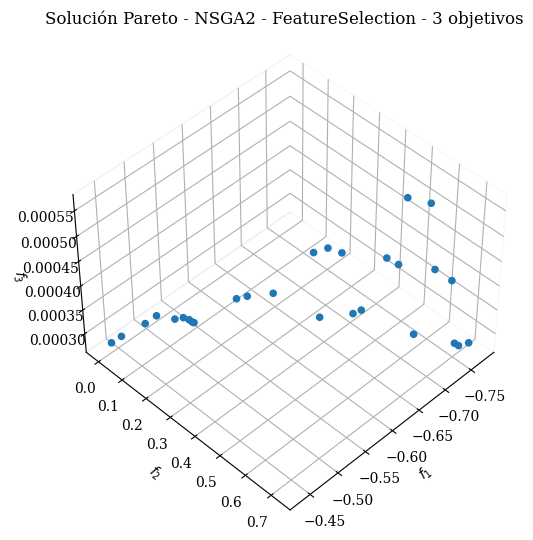

Individuos no dominados:  28
Individuo no dominado 0: 2 features seleccionadas, f1 = -0.5143, f2 = 0.0121, f3= 0.0003.
Individuo no dominado 1: 2 features seleccionadas, f1 = -0.5274, f2 = 0.0592, f3= 0.0003.
Individuo no dominado 2: 2 features seleccionadas, f1 = -0.5399, f2 = 0.0901, f3= 0.0003.
Individuo no dominado 3: 2 features seleccionadas, f1 = -0.7569, f2 = 0.6925, f3= 0.0003.
Individuo no dominado 4: 2 features seleccionadas, f1 = -0.4560, f2 = 0.0013, f3= 0.0003.
Individuo no dominado 5: 2 features seleccionadas, f1 = -0.6534, f2 = 0.1851, f3= 0.0003.
Individuo no dominado 6: 2 features seleccionadas, f1 = -0.7018, f2 = 0.4064, f3= 0.0003.
Individuo no dominado 7: 2 features seleccionadas, f1 = -0.5408, f2 = 0.1087, f3= 0.0003.
Individuo no dominado 8: 2 features seleccionadas, f1 = -0.7142, f2 = 0.4135, f3= 0.0003.
Individuo no dominado 9: 2 features seleccionadas, f1 = -0.5371, f2 = 0.0724, f3= 0.0003.
Individuo no dominado 10: 2 features seleccionadas, f1 = -0.6656, f2 = 

In [39]:
def VisualizacionSolucion(title,f):
    if (len(f[0])>2):
        VisualizacionPuntos(title,f)
        return
    
    fig, ax = plt.subplots()
    
    # Agregar las soluciones obtenidas
    x = [v[0] for v in f]
    y = [v[1] for v in f]
    ax.scatter(x, y, color='red', label='Solutions')

    # Mostrar el título
    plt.title(title)

    # Mostrar la leyenda
    plt.legend()    

    plt.grid(True)
    
    plt.show()
    
title = "Solución Pareto - "+algorithm.__class__.__name__ +" - "+problem.name()+" - "+str(problem.n_obj)+" objetivos"
VisualizacionSolucion(title,res.F)

def get_unique_nds(res):
    """
    Obtiene las soluciones no dominadas únicas de un conjunto de soluciones.

    Args:
        res (pymoo.core.result.Result): Resultado de la optimización.

    Returns:
        list: Índices de las soluciones no dominadas únicas.
    """
    # Obtener el índice de las soluciones no dominadas
    nds = NonDominatedSorting().do(res.F, only_non_dominated_front=True)
    
    # Eliminar soluciones duplicadas
    unique_nds_solutions = set()
    unique_nds_indexes = set()
    
    for i in range(len(nds)):
        s = tuple(res.F[nds[i]])
        if s not in unique_nds_solutions:
            unique_nds_solutions.add(s)
            unique_nds_indexes.add(nds[i])
    
    return list(unique_nds_indexes)

unique_nds_indexes = get_unique_nds(res)
        
print("Individuos no dominados: ",len(unique_nds_indexes))

for i,j in enumerate(unique_nds_indexes):
    s = res.F[j]
    c = np.sum(res.X[j])
    print(f"Individuo no dominado {i}: {c} features seleccionadas, f1 = {s[0]:.4f}, f2 = {s[1]:.4f}, f3= {s[2]:.4f}.")

Las soluciones como hemos dicho son vectores binarios de longitud 7129. En este caso hemos obtenido 28 soluciones no dominadas, todas con muy pocos atributos seleccionados, todas entre 2 y 4. Esto se debe a que los tres objetivos decrecen con la cardinalidad del subconjunto de atributos seleccionados y a que se han introducido en la población inicial soluciones con cardinalidad 2. En efecto, la correlación media entre los atributos seleccionados y el target es máxima cuando seleccionamos los 2 atributos más correlacionados con el target, y la correlación entre atributos seleccionados es mínima cuando seleccionamos los 2 atributos menos correlacionados entre sí. Al añadir cualquier atributo a la solución se decrementará uno de los dos objetivos. Por eso es de esperar que las soluciones no dominadas tengan muy baja cardinalidad. La solución con más atributos seleccionados es la 20 con 4 seleccionados, y tiene f1 = -0.7315, f2 = 0.6245. Su valor de f2 es muy alto respecto a la 25 que tiene f2 = 0.0002. Así que esta solución tiene atributos muy correlacionados con el target pero algo redundantes.

#### Indicadores de rendimiento

In [40]:
print("Base de datos:",DATASET_TRAIN_PATH)    
nadir = [1,0] # valores maximos [f1,f2]
maxArea = max_area
indicator = [
        GD(pf),
        GDPlus(pf),
        IGD(pf),
        IGDPlus(pf),
        hv_indicator
]
cadena = " \t \t "
print("NSGA2 \t \t \t ")
for iIndicator in range(len(indicator)):
    cadena = indicator[iIndicator].__class__.__name__+" \t "
    if (len(cadena)<10):
        cadena += " \t "
    cadena += str(indicator[iIndicator](res.F))+" \t "
    print(cadena)
cadena = "HV normalized \t "
cadena += str(indicator[len(indicator)-1](res.F)/maxArea)+" \t "
print(cadena)

Base de datos: ../DATASETS/ALL-AML_train.arff
NSGA2 	 	 	 
GD 	  	 0.5426697216821318 	 
GDPlus 	  	 0.33688104793359164 	 
IGD 	  	 0.6654679573988218 	 
IGDPlus 	 0.39285725864304316 	 
HV 	  	 0.6917026919683721 	 
HV normalized 	 0.6917026919683721 	 


En esta prueba se alcanzó un hipervolumen de 0.6917 en la población final. El hipervolumen está normalizado puesto que cada intervalo está en un rango que es un intervalo de longitud 1 ($[0,1]$ o $[-1,0]$).

#### Evolución de los indicadores de rendimiento

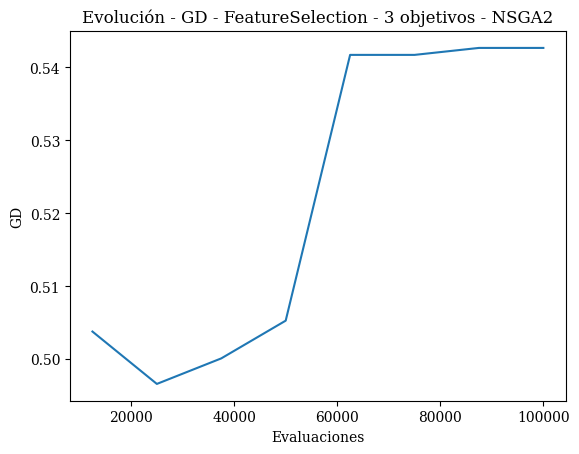

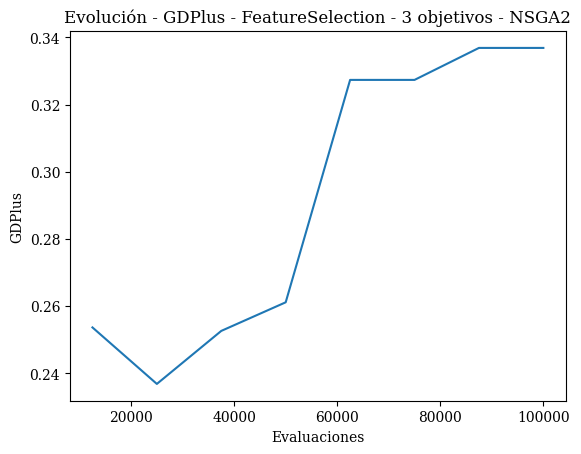

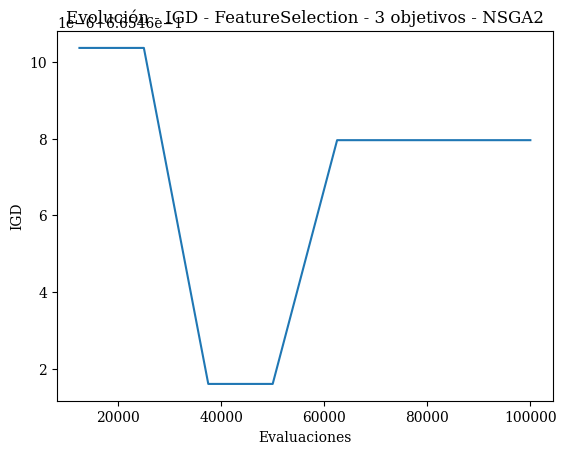

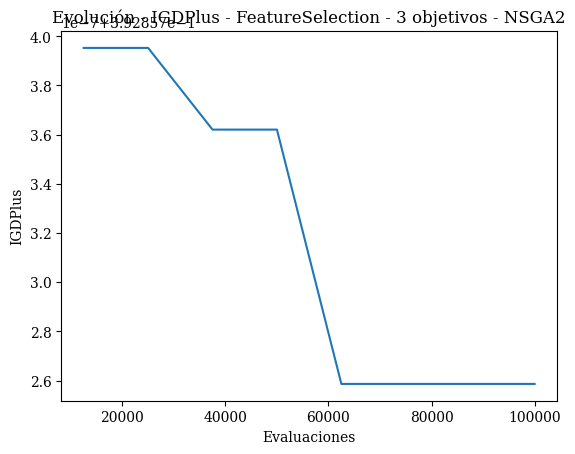

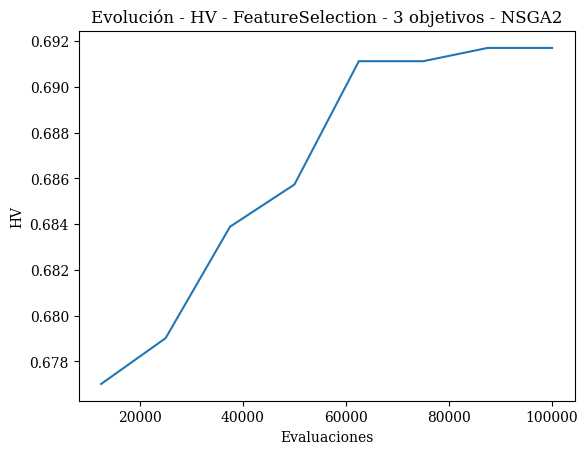

In [41]:
def VisualizacionEvolucion(title,res,values,yTitle):    
    n_evals = np.array([e.evaluator.n_eval for e in res.history]) # array con los números de evaluaciones
    fig, ax = plt.subplots()
    ax.set_title(title)
    plt.plot(n_evals, values)
    plt.xlabel("Evaluaciones")
    plt.ylabel(yTitle)
    plt.show() 

for iIndicator in range(len(indicator)):
    values = np.array([indicator[iIndicator](e.opt.get("F")) for e in res.history])
    title = "Evolución - "+indicator[iIndicator].__class__.__name__+" - "+problem.name()+" - "+str(problem.n_obj)+" objetivos - "+algorithm.__class__.__name__ 
    VisualizacionEvolucion(title,res,values,indicator[iIndicator].__class__.__name__)

En estas gráficas podemos ver la evolución de los indicadores de rendimiento a lo largo de las evaluaciones de la función objetivo realizadas por el MOEA, pero solo para 8 puntos a lo largo de la ejecución. Nos centraremos en el hipervolumen, que hemos muestreado con mayor frecuencia.

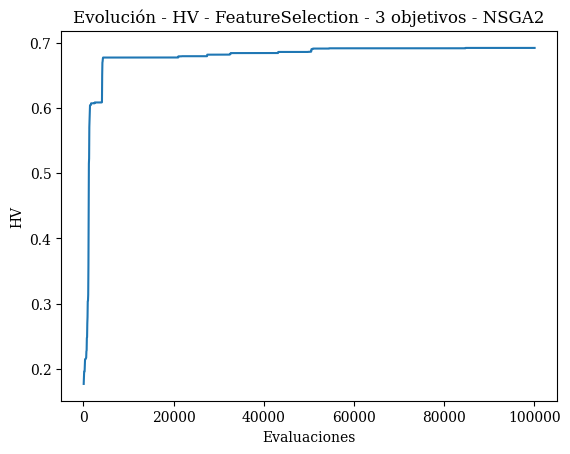

In [42]:
def VisualizacionEvolucionHV(title,n_evals,values,yTitle):    
    fig, ax = plt.subplots()
    ax.set_title(title)
    plt.plot(n_evals, values)
    plt.xlabel("Evaluaciones")
    plt.ylabel(yTitle)
    plt.show() 


name = hv_indicator.__class__.__name__
ns_gen = np.array([e['gen'] for e in alg_callback.history])
n_evals = pop_size*ns_gen
values = np.array([e['hv'] for e in alg_callback.history])
title = "Evolución - "+hv_indicator.__class__.__name__+" - "+problem.name()+" - "+str(problem.n_obj)+" objetivos - "+algorithm.__class__.__name__ 
VisualizacionEvolucionHV(title,n_evals,values,hv_indicator.__class__.__name__)

Vemos que para este ejemplo el hipervolumen es creciente con el número de evaluaciones, lo que indica que el algoritmo evolutivo ha ido mejorando la población de soluciones no dominadas a lo largo de las generaciones. El hipervolumen se estabiliza rápidamente en torno a 0.69, que es el valor al que converge esta ejecución del algoritmo. Antes de las 20000 evaluaciones ya se había alcanzado un valor muy cercano: la convergencia ha sido muy rápida. Debemos obtener esta gráfica de hipervolumen para las 10 seeds y la media más adelante, para analizar el rendimiento, la convergencia y la estabilidad del algoritmo evolutivo, que es un proceso aleatorio y depende de la semilla inicial.

#### Test con los modelos de clasificación

A continuación evaluamos las soluciones no dominadas obtenidas en esta primera ejecución del MOEA. Para los tres modelos de clasificación (RF, SVM y MLP) obtenemos la accuracy de crosvalidación para cada solución, y después nos quedamos con la mejor selección de atributos. Entrenamos el modelo con esa selección de atributos y evaluamos su accuracy en los conjuntos de train y test. 

* Gestión de los resultados: en el siguiente código definimos las columnas de los dataframes para guardar resultados de evaluación.

In [88]:
def getEstimators(random_state=None):
    estimators = [RandomForestClassifier(random_state=random_state), 
                SVC(random_state=random_state), 
                MLPClassifier(random_state=random_state)]
    return estimators

seed = SEED+0
estimators = getEstimators(random_state=seed)

# Guardar dataframe con columnas: seed, RF_train_acc, RF_test_acc, SVC_train_acc, SVC_test_acc, MLP_train_acc, MLP_test_acc

estimator_names = ['RF', 'SVC', 'MLP']
estimator_indexes = {name: i for i, name in enumerate(estimator_names)}

columns = ['seed', 'HV', 'time', 'nds']
for name in estimator_names:
    columns.append(name+'_train_acc')
for name in estimator_names:
    columns.append(name+'_test_acc')
for name in estimator_names:
    columns.append(name+'_val_acc')
for name in estimator_names:
    columns.append(name+'_c_features')

columns += ['c_min', 'c_max', 'f1_min', 'f1_max', 'f2_min', 'f2_max']

scores_dict0 = {col: [] for col in columns}

def add_results_to_dict(scores_dict, seed, hv, time, n_nds, train_scores, test_scores, val_scores,
                        c_features, c_min, c_max, f1_min, f1_max, f2_min, f2_max):
    # Agregar resultados al diccionario
    scores_dict['seed'].append(seed)
    scores_dict['HV'].append(hv)
    scores_dict['time'].append(time)
    scores_dict['nds'].append(n_nds)
    
    for i, name in enumerate(estimator_names):
        scores_dict[name+'_train_acc'].append(train_scores[i])
        scores_dict[name+'_test_acc'].append(test_scores[i])
        scores_dict[name+'_val_acc'].append(val_scores[i])
        scores_dict[name+'_c_features'].append(c_features[i])
    
    scores_dict['c_min'].append(c_min)
    scores_dict['c_max'].append(c_max)
    scores_dict['f1_min'].append(f1_min)
    scores_dict['f1_max'].append(f1_max)
    scores_dict['f2_min'].append(f2_min)
    scores_dict['f2_max'].append(f2_max)
    
    return scores_dict

def add_results_to_df(df, seed, hv, time, n_nds, train_scores, test_scores, val_scores,
                      c_features, c_min, c_max, f2_min, f2_max):
    # Crear un nuevo DataFrame con los resultados
    new_row = {
        'seed': seed,
        'HV': hv,
        'time': time,
        'nds': n_nds
    }
    
    for i, name in enumerate(estimator_names):
        new_row[name+'_train_acc'] = train_scores[i]
        new_row[name+'_test_acc'] = test_scores[i]
        new_row[name+'_val_acc'] = val_scores[i]
        new_row[name+'_c_features'] = c_features[i]
    
    new_row['c_min'] = c_min
    new_row['c_max'] = c_max
    new_row['f1_min'] = f2_min
    new_row['f1_max'] = f2_max
    new_row['f2_min'] = f2_min
    new_row['f2_max'] = f2_max
    
    # Concatenar el nuevo DataFrame al existente
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
    
    return df

Obtenemos las métricas correspondientes a la población de soluciones:
- **Hipervolumen**
- **Número de soluciones no dominadas**
- **Mejor y peor valor de la función objetivo**, para cada uno de los tres objetivos.

In [44]:
hv = hv_indicator(res.F)

nds = get_unique_nds(res) # Obtener soluciones no dominadas sin duplicados
nd_solutions = res.X[nds]
n_nds = len(nd_solutions)
print("Número de soluciones no dominadas: ",n_nds)

new_row = {
    'seed': seed,
    'HV': hv,
    'nds': n_nds,
}

c_min = np.sum(res.X[nds,:], axis=1).min()
c_max = np.sum(res.X[nds,:], axis=1).max()
f1_min = res.F[nds][:, 0].min()
f1_max = res.F[nds][:, 0].max()
f2_min = res.F[nds][:, 1].min()
f2_max = res.F[nds][:, 1].max()

train_scores = []
test_scores = []
val_scores = []
c_features = []

Número de soluciones no dominadas:  28


* Ejecución de las evaluaciones:

In [45]:
if not DONE:
    for estimator in estimators:
        j_max = 0
        val_max = -1
        
        print("Entrenando clasificador: ", estimator.__class__.__name__)
        for i, solution in enumerate(nd_solutions):
            n_selected = np.sum(solution)
            #print(f"Evaluando solución {i+1}/{len(nd_solutions)} con {n_selected} features")
            selected_features = np.where(solution == 1)[0]
            X = X_train.iloc[:, selected_features]

            val_accuracy = cross_val_score(estimator, X, y_train, cv=cv)
            mean_val_accuracy = np.mean(val_accuracy)
            if mean_val_accuracy > val_max:
                j_max = i
                val_max = mean_val_accuracy
        
        c = np.sum(nd_solutions[j_max])        
        print("Mejor solución: ", j_max, " con ", val_max, "acc de validación y ", c, " features")
        c_features.append(c)
        
        selected_features = np.where(nd_solutions[j_max] == 1)[0]
        X = X_train.iloc[:, selected_features]
        estimator.fit(X, y_train)
        
        train_accuracy = estimator.score(X, y_train)
        test_accuracy = estimator.score(X_test.iloc[:,selected_features], y_test)
        val_accuracy = val_max
        
        train_scores.append(train_accuracy)
        test_scores.append(test_accuracy)
        val_scores.append(val_accuracy)
        
        print(f"Validation accuracy: {val_accuracy}")
        print(f"Train accuracy: {train_accuracy}")
        print(f"Test accuracy: {test_accuracy}")
        
        print("----------------------")


    # Guardar resultados en el diccionario
    add_results_to_dict(scores_dict0, seed, hv, evolution_time, n_nds, train_scores, test_scores, val_scores, c_features,
                        c_min, c_max, f1_min, f1_max, f2_min, f2_max)

Entrenando clasificador:  RandomForestClassifier
Mejor solución:  3  con  0.9722222222222222 acc de validación y  2  features
Validation accuracy: 0.9722222222222222
Train accuracy: 1.0
Test accuracy: 0.9117647058823529
----------------------
Entrenando clasificador:  SVC
Mejor solución:  13  con  0.9722222222222222 acc de validación y  2  features
Validation accuracy: 0.9722222222222222
Train accuracy: 0.9736842105263158
Test accuracy: 0.9117647058823529
----------------------
Entrenando clasificador:  MLPClassifier
Mejor solución:  18  con  0.95 acc de validación y  3  features
Validation accuracy: 0.95
Train accuracy: 0.9736842105263158
Test accuracy: 0.9411764705882353
----------------------


Con soluciones de entre 2 y 3 atributos seleccionados se obtienen accuracies de test superiores a 0.9 en los tres modelos.

In [15]:
# Guardar resultados

path_csv_scores = os.path.join(RESULTS_DIR, "scores-0.csv")

if not LOAD:
    df = pd.DataFrame(scores_dict0)

    if not os.path.exists(RESULTS_DIR):
        os.makedirs(RESULTS_DIR)
        
    df.to_csv(path_csv_scores)
else:
    # Cargar resultados
    scores_df0 = pd.read_csv(path_csv_scores)
    
    scores_dict0 = scores_df0.to_dict(orient='list')

In [ ]:
scores_df0 = pd.DataFrame(scores_dict0)
display(scores_df0)

seed        HV         time  nds  RF_train_acc  SVC_train_acc  \
0  2025  0.691703  1068.171905   28           1.0       0.973684   

   MLP_train_acc  RF_test_acc  SVC_test_acc  MLP_test_acc  ...  MLP_val_acc  \
0       0.973684     0.911765      0.911765      0.941176  ...         0.95   

   RF_c_features  SVC_c_features  MLP_c_features  c_min  c_max    f1_min  \
0              2               2               3      2      4 -0.770679   

     f1_max   f2_min    f2_max  
0 -0.438808  0.00016  0.720187  

[1 rows x 22 columns]

Resta repetir este experimento con 10 seeds diferentes y analizar los resultados. Antes de eso evaluaremos la solución baseline.

### 4.2. Baseline: Evaluar modelos con todas las features

La solución más sencilla de la selección de atributos es usar todos los atributos. Usaremos esta solución como baseline para compararlo con las obtenidas por el MOEA. Para ello entrenamos los tres modelos de clasificación (RF, SVM y MLP) con todos los atributos y calculamos la accuracy en validación, train y test. Lo hacemos para 10 semillas distintas, porque MLP depende de la inicialización aleatoria de los pesos y RF también depende de la semilla.

In [48]:
scores_all_dict = {col: [] for col in columns}
if not DONE:
    for t in range(1,11):
        seed = SEED + t
        estimators = getEstimators(random_state=seed)
        train_scores = []
        test_scores = []
        val_scores = []
        print("Semilla: ", seed)
        for estimator in estimators:
            print(f"Entrenando clasificador: {estimator.__class__.__name__}")
            estimator.fit(X_train[:], y_train)
            
            train_accuracy = estimator.score(X_train[:], y_train)
            test_accuracy = estimator.score(X_test[:], y_test)
            
            
            train_scores.append(train_accuracy)
            test_scores.append(test_accuracy)
            
            # K-fold CV Validation accuracy
            
            val_accuracy = cross_val_score(estimator, X_train[:], y_train, cv=cv)
            mean_val_accuracy = np.mean(val_accuracy)
            val_scores.append(mean_val_accuracy)
            
            print(f"Validation accuracy: {mean_val_accuracy}")
            print(f"Train accuracy: {train_accuracy}")
            print(f"Test accuracy: {test_accuracy}")

        hv = 0
        
        n_nds = 1
        c_features = [n_features] * len(estimator_names)
        c_min = n_features
        c_max = n_features
        f1_min = -1*problem.f1(np.ones(n_features), n_features)
        f1_max = -1*f1_min
        f2_min = problem.f2(np.ones(n_features), n_features)
        f2_max = f2_min
        
        # Agregar resultados al diccionario
        scores_all_dict = add_results_to_dict(scores_all_dict, seed, hv, 0, n_nds, train_scores, test_scores, val_scores,
                                            c_features, c_min, c_max, f1_min, f1_max, f2_min, f2_max)
        print("----------------------")

Semilla:  2026
Entrenando clasificador: RandomForestClassifier
Validation accuracy: 0.8416666666666666
Train accuracy: 1.0
Test accuracy: 0.7941176470588235
Entrenando clasificador: SVC
Validation accuracy: 0.7249999999999999
Train accuracy: 0.8157894736842105
Test accuracy: 0.6176470588235294
Entrenando clasificador: MLPClassifier
Validation accuracy: 0.8944444444444445
Train accuracy: 0.9210526315789473
Test accuracy: 0.8235294117647058
----------------------
Semilla:  2027
Entrenando clasificador: RandomForestClassifier
Validation accuracy: 0.9055555555555554
Train accuracy: 1.0
Test accuracy: 0.7941176470588235
Entrenando clasificador: SVC
Validation accuracy: 0.7249999999999999
Train accuracy: 0.8157894736842105
Test accuracy: 0.6176470588235294
Entrenando clasificador: MLPClassifier
Validation accuracy: 0.7930555555555556
Train accuracy: 1.0
Test accuracy: 0.8529411764705882
----------------------
Semilla:  2028
Entrenando clasificador: RandomForestClassifier
Validation accuracy:

In [66]:
# Guardar resultados

path_csv_scores_all = os.path.join(RESULTS_DIR, "scores-all.csv")

if not LOAD:
    df = pd.DataFrame(scores_all_dict)

    if not os.path.exists(RESULTS_DIR):
        os.makedirs(RESULTS_DIR)
        
    df.to_csv(path_csv_scores_all)

else:
    # Cargar resultados
    df = pd.read_csv(path_csv_scores_all, index_col=0)
    
    scores_all_dict = df.to_dict(orient='list')
    scores_all_df = df.copy()

In [69]:
# Remove Unnamed: 0 column
if LOAD:
    if 'Unnamed: 0' in scores_all_df.columns:
        print("Removed unnamed column")
        scores_all_df = scores_all_df.drop(columns=['Unnamed: 0'])
        scores_all_dict = scores_all_df.to_dict(orient='list')

#### Tabla de resultados del baseline (por seed)

In [70]:
scores_all_df = pd.DataFrame(scores_all_dict)
display(scores_all_df)

seed  HV  time  nds  RF_train_acc  SVC_train_acc  MLP_train_acc  \
0  2026   0     0    1           1.0       0.815789       0.921053   
1  2027   0     0    1           1.0       0.815789       1.000000   
2  2028   0     0    1           1.0       0.815789       1.000000   
3  2029   0     0    1           1.0       0.815789       0.947368   
4  2030   0     0    1           1.0       0.815789       0.973684   
5  2031   0     0    1           1.0       0.815789       1.000000   
6  2032   0     0    1           1.0       0.815789       0.973684   
7  2033   0     0    1           1.0       0.815789       1.000000   
8  2034   0     0    1           1.0       0.815789       1.000000   
9  2035   0     0    1           1.0       0.815789       1.000000   

   RF_test_acc  SVC_test_acc  MLP_test_acc  ...  MLP_val_acc  RF_c_features  \
0     0.794118      0.617647      0.823529  ...     0.894444           7129   
1     0.794118      0.617647      0.852941  ...     0.793056           7129   
2     0.764706      0.617647      0.911765  ...     0.827778           7129   
3     0.794118      0.617647      0.852941  ...     0.948611           7129   
4     0.823529      0.617647      0.852941  ...     0.920833           7129   
5     0.764706      0.617647      0.882353  ...     0.961111           7129   
6     0.823529      0.617647      0.882353  ...     0.866667           7129   
7     0.794118      0.617647      0.911765  ...     0.919444           7129   
8     0.794118      0.617647      0.911765  ...     0.973611           7129   
9     0.764706      0.617647      0.941176  ...     0.866667           7129   

   SVC_c_features  MLP_c_features  c_min  c_max    f1_min    f1_max    f2_min  \
0            7129            7129   7129   7129 -0.211047  0.211047  0.190524   
1            7129            7129   7129   7129 -0.211047  0.211047  0.190524   
2            7129            7129   7129   7129 -0.211047  0.211047  0.190524   
3            7129            7129   7129   7129 -0.211047  0.211047  0.190524   
4            7129            7129   7129   7129 -0.211047  0.211047  0.190524   
5            7129            7129   7129   7129 -0.211047  0.211047  0.190524   
6            7129            7129   7129   7129 -0.211047  0.211047  0.190524   
7            7129            7129   7129   7129 -0.211047  0.211047  0.190524   
8            7129            7129   7129   7129 -0.211047  0.211047  0.190524   
9            7129            7129   7129   7129 -0.211047  0.211047  0.190524   

     f2_max  
0  0.190524  
1  0.190524  
2  0.190524  
3  0.190524  
4  0.190524  
5  0.190524  
6  0.190524  
7  0.190524  
8  0.190524  
9  0.190524  

[10 rows x 22 columns]

Aparte de las métricas de clasificación de los modelos de ML, hemos añadido el valor de los objetivos f1 y f2 de la solución baseline (seleccionar todos los atributos), que tienen valores de 0.21 y 0.1905.

In [71]:
# Exclude 'HV' and 'time' columns from the DataFrame
exclude_columns = ['HV', 'time', 'nds', 'c_min', 'c_max', 'f1_max', 'f2_max']
for e in estimator_names:
    exclude_columns.append(e+'_c_features')
df_all = pd.DataFrame({key: value for key, value in scores_all_dict.items() if key not in exclude_columns})
display(df_all)

seed  RF_train_acc  SVC_train_acc  MLP_train_acc  RF_test_acc  \
0  2026           1.0       0.815789       0.921053     0.794118   
1  2027           1.0       0.815789       1.000000     0.794118   
2  2028           1.0       0.815789       1.000000     0.764706   
3  2029           1.0       0.815789       0.947368     0.794118   
4  2030           1.0       0.815789       0.973684     0.823529   
5  2031           1.0       0.815789       1.000000     0.764706   
6  2032           1.0       0.815789       0.973684     0.823529   
7  2033           1.0       0.815789       1.000000     0.794118   
8  2034           1.0       0.815789       1.000000     0.794118   
9  2035           1.0       0.815789       1.000000     0.764706   

   SVC_test_acc  MLP_test_acc  RF_val_acc  SVC_val_acc  MLP_val_acc    f1_min  \
0      0.617647      0.823529    0.841667        0.725     0.894444 -0.211047   
1      0.617647      0.852941    0.905556        0.725     0.793056 -0.211047   
2      0.617647      0.911765    0.866667        0.725     0.827778 -0.211047   
3      0.617647      0.852941    0.908333        0.725     0.948611 -0.211047   
4      0.617647      0.852941    0.868056        0.725     0.920833 -0.211047   
5      0.617647      0.882353    0.918056        0.725     0.961111 -0.211047   
6      0.617647      0.882353    0.894444        0.725     0.866667 -0.211047   
7      0.617647      0.911765    0.841667        0.725     0.919444 -0.211047   
8      0.617647      0.911765    0.879167        0.725     0.973611 -0.211047   
9      0.617647      0.941176    0.931944        0.725     0.866667 -0.211047   

     f2_min  
0  0.190524  
1  0.190524  
2  0.190524  
3  0.190524  
4  0.190524  
5  0.190524  
6  0.190524  
7  0.190524  
8  0.190524  
9  0.190524

In [72]:
# Reportar tabla con columnas: seed, hv, time, rf_train_acc, rf_test_acc, svc_train_acc, svc_test_acc, mlp_train_acc, mlp_test_acc
# añadir filas adicionales: mejor, peor, media y desviación típica

# Crear un nuevo DataFrame con los resultados
summary_all_dict = {}
summary_all_dict['seed'] = ['best', 'worst', 'mean', 'std']
estimator_names = ['RF', 'SVC', 'MLP']

for metric in ['train_acc', 'test_acc']:
    for i, name in enumerate(estimator_names):
        metric_name = f"{name}_{metric}"
        metric_values = scores_all_df[metric_name].to_numpy()
        if metric != 'c_features':
            summary_all_dict[metric_name] = [np.max(metric_values), np.min(metric_values), np.mean(metric_values), np.std(metric_values)]
        else:
            summary_all_dict[metric_name] = [np.min(metric_values), np.max(metric_values), np.mean(metric_values), np.std(metric_values)]

summary_all_df = pd.DataFrame(summary_all_dict)
summary_all_df = summary_all_df.set_index('seed')
# renombrar columna seed a stat
summary_all_df = summary_all_df.rename_axis('stat')

display(summary_all_df)

RF_train_acc  SVC_train_acc  MLP_train_acc  RF_test_acc  SVC_test_acc  \
stat                                                                           
best            1.0   8.157895e-01       1.000000     0.823529  6.176471e-01   
worst           1.0   8.157895e-01       0.921053     0.764706  6.176471e-01   
mean            1.0   8.157895e-01       0.981579     0.791176  6.176471e-01   
std             0.0   1.110223e-16       0.026447     0.020588  1.110223e-16   

       MLP_test_acc  
stat                 
best       0.941176  
worst      0.823529  
mean       0.882353  
std        0.034800

Reportamos también la media, el mejor, el peor y la varianza de los accuracies para cada modelo, en train y test. El mejor modelo fue el MLP con una accuracy media en test de 0.88. Observamos que:
* Random Forest presenta overfitting, con un accuracy en train de 1 en todos los casos debido al bajo número de ejemplos de entrenamiento (38). La accuracy media en test es de 0.79 y tiene una desviación típica baja (0.02).
* SVM: también presenta overfitting, con un accuracy medio en train de 0.82 y en test de 0.617. SVM no depende de la semilla así que la varianza es 0.
* MLP también presenta overfitting, con un accuracy en train muy cercano a 1, pero es el modelo que mejor accuracy medio en test tiene (0.88) y además en el mejor caso de 0.941.

### 4.3. Varias SEED

Realizamos la parte fundamental del estudio, que es la evaluación del MOEA para 10 semillas distintas, tomando medidas en la población de soluciones (hipervolumen, número de soluciones no dominadas, mejor y peor valor de la función objetivo) y evaluando los modelos de ML con las mejores soluciones no dominadas obtenidas. Los resultados se guardan en un dataframe.

In [53]:
print("Problema: ",DATASET_TRAIN_PATH)
print("Algoritmo: NSGA2")

scores_dict = {col: [] for col in columns}
seeds = np.arange(SEED+1, SEED+11)
times = np.zeros((len(seeds),))
results = []
hvs = np.zeros((len(seeds),))

alg_callbacks = []
if not DONE:
    for t in range(1,11):
        print(f"Ejecutando prueba {t} de 10")
        
        seed = SEED+t
        np.random.seed(seed)
        random_state = seed
        
        alg_callback = SparseCallback(step=-1)
        algorithm = getAlgorithm(random_state=random_state)
        start_time = time.time()
        
        res = minimize(problem=problem,
                        algorithm=algorithm,
                        termination=termination,
                        seed=random_state,
                        save_history=False,
                        verbose=True,
                        callback=alg_callback)
        
        end_time = time.time()
        
        evolution_time = end_time - start_time
        print(f"Tiempo de evolución: {evolution_time:.2f} segundos")
        
        hv = hv_indicator(res.F)
        
        results.append(res)
        alg_callbacks.append(alg_callback)
        times[t-1] = evolution_time
        hvs[t-1] = hv
       

Problema:  ../DATASETS/ALL-AML_train.arff
Algoritmo: NSGA2
Ejecutando prueba 1 de 10
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      igd      |       gd      |       hv     
     1 |       48 |      2 |  0.000000E+00 |  0.000000E+00 |  0.9187055958 |  0.2443336671 |  0.2574693079
     2 |       98 |      2 |  0.000000E+00 |  0.000000E+00 |  0.9187055958 |  0.2443336671 |  0.2574693079
     3 |      148 |      3 |  0.000000E+00 |  0.000000E+00 |  0.9187055958 |  0.2478338342 |  0.2575588044
     4 |      198 |      3 |  0.000000E+00 |  0.000000E+00 |  0.9187055958 |  0.2478338342 |  0.2575588044
     5 |      248 |      3 |  0.000000E+00 |  0.000000E+00 |  0.9187055958 |  0.2478338342 |  0.2575588044
     6 |      298 |      3 |  0.000000E+00 |  0.000000E+00 |  0.9187055958 |  0.2478338342 |  0.2575588044
     7 |      348 |      3 |  0.000000E+00 |  0.000000E+00 |  0.9187055958 |  0.2478338342 |  0.2575588044
     8 |      398 |      3 |  0.000000E+00 |  0.000000E+00 

In [54]:
if not DONE:
    for t in range(1,11):
        print(f"Ejecutando prueba {t} de 10")
        
        seed = SEED+t
        np.random.seed(seed)
        random_state = seed
        
        res = results[t-1]
        hv = hvs[t-1]
        evolution_time = times[t-1]
        
        nds = get_unique_nds(res) # Obtener soluciones no dominadas sin duplicados
        nd_solutions = res.X[nds]
        n_nds = len(nd_solutions)
        
        cs = np.sum(res.X[nds,:], axis=1)
        c_min = cs.min()
        c_max = cs.max()
        f1_min = res.F[nds][:, 0].min()
        f1_max = res.F[nds][:, 0].max()
        f2_min = res.F[nds][:, 1].min()
        f2_max = res.F[nds][:, 1].max()
        
        estimators = getEstimators(random_state=seed)
        train_scores = []
        test_scores = []
        val_scores = []
        c_features = []
        
        for estimator in estimators:
            j_max = 0
            val_max = -1
            print("Entrenando clasificador: ", estimator.__class__.__name__)
            for i, solution in enumerate(nd_solutions):
                n_selected = np.sum(solution)
                #print(f"Evaluando solución {i+1}/{len(nd_solutions)} con {n_selected} features")
                selected_features = np.where(solution == 1)[0]
                X = X_train.iloc[:, selected_features]

                val_accuracy = cross_val_score(estimator, X, y_train, cv=cv)
                mean_val_accuracy = np.mean(val_accuracy)
                if mean_val_accuracy > val_max:
                    j_max = i
                    val_max = mean_val_accuracy
            
            c = np.sum(nd_solutions[j_max])
            c_features.append(c)        
            print("Mejor solución: ", j_max, " con ", val_max, "acc de validación y ", c, " features")
            
            selected_features = np.where(nd_solutions[j_max] == 1)[0]
            X = X_train.iloc[:, selected_features]
            estimator.fit(X, y_train)
            
            train_accuracy = estimator.score(X, y_train)
            test_accuracy = estimator.score(X_test.iloc[:,selected_features], y_test)
            val_accuracy = val_max
            
            train_scores.append(train_accuracy)
            test_scores.append(test_accuracy)
            val_scores.append(val_accuracy)
            
            print(f"Validation accuracy: {val_accuracy}")
            print(f"Train accuracy: {train_accuracy}")
            print(f"Test accuracy: {test_accuracy}")
            print("---------")
            print()
        add_results_to_dict(scores_dict, seed, hv, evolution_time, n_nds, train_scores, test_scores, val_scores,
                            c_features, c_min, c_max, f1_min, f1_max, f2_min, f2_max)
        

        print("--------------------")

Ejecutando prueba 1 de 10
Entrenando clasificador:  RandomForestClassifier
Mejor solución:  4  con  0.9486111111111111 acc de validación y  2  features
Validation accuracy: 0.9486111111111111
Train accuracy: 1.0
Test accuracy: 0.4411764705882353
---------

Entrenando clasificador:  SVC
Mejor solución:  6  con  0.9347222222222222 acc de validación y  3  features
Validation accuracy: 0.9347222222222222
Train accuracy: 0.9736842105263158
Test accuracy: 0.7647058823529411
---------

Entrenando clasificador:  MLPClassifier
Mejor solución:  5  con  0.8430555555555556 acc de validación y  2  features
Validation accuracy: 0.8430555555555556
Train accuracy: 0.8157894736842105
Test accuracy: 0.7058823529411765
---------

--------------------
Ejecutando prueba 2 de 10
Entrenando clasificador:  RandomForestClassifier
Mejor solución:  6  con  1.0 acc de validación y  3  features
Validation accuracy: 1.0
Train accuracy: 1.0
Test accuracy: 0.8823529411764706
---------

Entrenando clasificador:  SVC
M

In [73]:
# Guardar resultados

path_csv_scores = os.path.join(RESULTS_DIR, "scores-10.csv")
results_pikle = os.path.join(RESULTS_DIR, "results-10.pkl")
callbacks_pikle = os.path.join(RESULTS_DIR, "callbacks-10.pkl")

if not LOAD:
    df = pd.DataFrame(scores_dict)

    if not os.path.exists(RESULTS_DIR):
        os.makedirs(RESULTS_DIR)
        
    df.to_csv(path_csv_scores)

    with open(results_pikle, 'wb') as f:
        pickle.dump(results, f)
    
    
    with open(callbacks_pikle, 'wb') as f:
        pickle.dump(alg_callbacks, f)
else:
    # Cargar resultados
    df = pd.read_csv(path_csv_scores)
    with open(results_pikle, 'rb') as f:
        results = pickle.load(f)
    
    with open(callbacks_pikle, 'rb') as f:
        alg_callbacks = pickle.load(f)
    
    scores_dict = df.to_dict(orient='list')
    scores_df = df.copy()

In [75]:
# remove Unnamed: 0 column
if LOAD:
    if 'Unnamed: 0' in scores_df.columns:
        print("Removed unnamed column")
        scores_df = scores_df.drop(columns=['Unnamed: 0'])
        scores_dict = scores_df.to_dict(orient='list')

## 5. Análisis de resultados

A continuación presentamos los resultados de la experimentación para selección de atributos multiobjetivo en ALL-AML.

### Tabla de resultados de selección de atributos multiobjetivo por seed

En la siguiente tabla se obtienen las métricas requeridas para cada una de las 10 semillas: hipervolumen de la población final, accuracy en train y test de los tres modelos (RF, SVM y MLP), entrenados con los atributos seleccionados de la mejor solución del MOEA (según su accuracy de validación). Hemos añadido también el número de soluciones no dominadas (nds), el tiempo de ejecución del MOEA, el número de atributos generados de la mejor solución en validación para cada modelo (c_features), y los valores objetivos máximo y mínimo para cada uno (f1, f2 y c, que es el número de atributos seleccionados).

In [56]:
scores_df = pd.DataFrame(scores_dict)
display(scores_df)

seed        HV         time  nds  RF_train_acc  SVC_train_acc  \
0  2026  0.652032  1036.418258    8           1.0       0.973684   
1  2027  0.695914  1019.634135   19           1.0       1.000000   
2  2028  0.697524  1073.365523   23           1.0       0.973684   
3  2029  0.694491  1060.519831   12           1.0       1.000000   
4  2030  0.644234  1040.020012   17           1.0       0.973684   
5  2031  0.704978  1074.613591   21           1.0       0.973684   
6  2032  0.619618  1049.794205   17           1.0       0.921053   
7  2033  0.630753  1038.145378   18           1.0       0.894737   
8  2034  0.678562  1050.079131   15           1.0       0.973684   
9  2035  0.685115  1091.382078   17           1.0       0.973684   

   MLP_train_acc  RF_test_acc  SVC_test_acc  MLP_test_acc  ...  MLP_val_acc  \
0       0.815789     0.441176      0.764706      0.705882  ...     0.843056   
1       0.973684     0.882353      0.852941      0.911765  ...     0.973611   
2       1.000000     0.911765      0.911765      0.941176  ...     1.000000   
3       0.921053     0.852941      0.794118      0.676471  ...     0.920833   
4       1.000000     0.852941      0.941176      0.735294  ...     0.934722   
5       1.000000     0.794118      0.794118      0.735294  ...     0.975000   
6       0.815789     0.735294      0.647059      0.470588  ...     0.830556   
7       0.947368     0.794118      0.794118      0.882353  ...     0.944444   
8       0.842105     0.735294      0.794118      0.558824  ...     0.868056   
9       1.000000     0.735294      0.794118      0.705882  ...     0.947222   

   RF_c_features  SVC_c_features  MLP_c_features  c_min  c_max    f1_min  \
0              2               3               2      2      3 -0.682076   
1              3               3               3      2      3 -0.760039   
2              2               2               2      2      4 -0.784670   
3              2               2               3      2      3 -0.749815   
4              3               3               3      2      4 -0.687457   
5              2               3               2      2      4 -0.819735   
6              3               2               2      2      3 -0.656248   
7              3               2               3      2      4 -0.667219   
8              3               3               2      2      3 -0.739655   
9              2               2               3      2      3 -0.761478   

     f1_max    f2_min    f2_max  
0 -0.476509  0.003205  0.400308  
1 -0.432947  0.001125  0.442137  
2 -0.474722  0.001735  0.675586  
3 -0.450922  0.001226  0.489272  
4 -0.367419  0.001037  0.725818  
5 -0.348703  0.000253  0.747379  
6 -0.294078  0.000987  0.504619  
7 -0.291871  0.000524  0.595968  
8 -0.432588  0.000072  0.547742  
9 -0.553670  0.001876  0.703025  

[10 rows x 22 columns]

Observamos que para las 10 semillas el número de features seleccionados está entre 2 y 4. Puede parecer que al tener muy poca cardinalidad las soluciones son menos diversas, pero aún así hay un gran número de soluciones no dominadas (no repetidas): entre 8 y 23. A continuación obtenemos el resumen estadístico de estas métricas, con el que analizaremos directamente el rango, la media y la desviación típica de cada una.

In [76]:
# Reportar tabla con columnas: seed, hv, time, rf_train_acc, rf_test_acc, svc_train_acc, svc_test_acc, mlp_train_acc, mlp_test_acc
# añadir filas adicionales: mejor, peor, media y desviación típica

# Crear un nuevo DataFrame con los resultados
summary_dict = {}
summary_dict['seed'] = ['best', 'worst', 'mean', 'std']
estimator_names = ['RF', 'SVC', 'MLP']

hvs = scores_df['HV'].to_numpy()
summary_dict['HV'] = [np.max(hvs), np.min(hvs), np.mean(hvs), np.std(hvs)]

times = scores_df['time'].to_numpy()
summary_dict['time'] = [np.min(times), np.max(times), np.mean(times), np.std(times)]

for metric in ['train_acc', 'test_acc', 'c_features']:
    for i, name in enumerate(estimator_names):
        metric_name = f"{name}_{metric}"
        metric_values = scores_df[metric_name].to_numpy()
        if metric != 'c_features':
            summary_dict[metric_name] = [np.max(metric_values), np.min(metric_values), np.mean(metric_values), np.std(metric_values)]
        else:
            summary_dict[metric_name] = [np.min(metric_values), np.max(metric_values), np.mean(metric_values), np.std(metric_values)]

for m1 in ['c', 'f1', 'f2']:
    for m2 in ['min', 'max']: 
        metric_name = f"{m1}_{m2}"
        metric_values = scores_df[metric_name].to_numpy()
        summary_dict[metric_name] = [np.min(metric_values), np.max(metric_values), np.mean(metric_values), np.std(metric_values)]

summary_df = pd.DataFrame(summary_dict)
summary_df = summary_df.set_index('seed')
# renombrar columna seed a stat
summary_df = summary_df.rename_axis('stat')

display(summary_df)


HV         time  RF_train_acc  SVC_train_acc  MLP_train_acc  \
stat                                                                       
best   0.704978  1019.634135           1.0       1.000000       1.000000   
worst  0.619618  1091.382078           1.0       0.894737       0.815789   
mean   0.670322  1053.397214           1.0       0.965789       0.931579   
std    0.029357    20.509118           0.0       0.031248       0.074618   

       RF_test_acc  SVC_test_acc  MLP_test_acc  RF_c_features  SVC_c_features  \
stat                                                                            
best      0.911765      0.941176      0.941176            2.0             2.0   
worst     0.441176      0.647059      0.470588            3.0             3.0   
mean      0.773529      0.808824      0.732353            2.5             2.5   
std       0.126197      0.076978      0.141940            0.5             0.5   

       MLP_c_features  c_min     c_max    f1_min    f1_max    f2_min    f2_max  
stat                                                                            
best              2.0    2.0  3.000000 -0.819735 -0.553670  0.000072  0.400308  
worst             3.0    2.0  4.000000 -0.656248 -0.291871  0.003205  0.747379  
mean              2.5    2.0  3.400000 -0.730839 -0.412343  0.001204  0.583185  
std               0.5    0.0  0.489898  0.051866  0.080544  0.000864  0.118302

Del resumen estadístico de las métricas obtenidas observamos:
* El hipervolumen medio es 0.6703 y tiene una desviación típica muy baja (0.02). Esto indica que el MOEA es muy estable para este problema de selección de atributos multiobjetivo, y no varía demasiado entre distintas ejecuciones. El hipervolumen mínimo es 0.619 y el máximo es 0.704.
* El tiempo medio de ejecución del MOEA es de aproximadamente 18 minutos.
* El número de atributos seleccionados de la mejor solución en validación está entre 2 y 3 en todos los casos y todos los modelos. Es un valor muy bajo que explicamos por el carácter de los tres objetivos del problema, que disminuyen con la cardinalidad del subconjunto de atributos seleccionados.
* En cuanto al accuracy de los modelos:
  * En RF siempre se obtiene un accuracy en train de 1, debido al bajo número de instancias del dataset (38). En test el accuracy medio es de 0.77 y tiene una desviación típica alta (0.126), siendo la peor medida 0.44 y la mejor 0.91. Este modelo es muy sensible al subconjunto de atributos seleccionado, que va tiene una cardinalidad de entre 2 y 3 en todas las soluciones. Lo explicamos porque debido al número muy pequeño de instancias el modelo sufre de overfitting, lo que se ve en el accuracy en train de 1.
  * SVC tiene unos resultados más robustos, con un accuracy medio en train de 0.965 y en test de 0.809, con una desviación típica algo menor (0.08). La variabilidad también es considerable, pues el accuracy en test va desde 0.647 a 0.941.
  * MLP también presenta un alto overfitting, con un accuracy medio en train de 0.93 y en test de 0.73. La variabilidad es la mayor: la desviación típica del accuracy en test es 0.14, y el rango va desde 0.47 a 0.94.
  * Los tres modelos sufren de un alto overfitting, al entrenarse con 2 o 3 atributos sobre un número pequeño de instancias.
* En cuanto a los valores de los objetivos:
  * f2 es muy bajo para todas las runs, con un valor mínimo (para la población) medio de 0.001204 y una desviación típica de 0.000864. El rango va de 7.2e-5 a 3e-3.
  * f1 es el que más varía entre runs, con un valor mínimo medio de -0.73, una desviación típica de 0.05 y un rango de -0.81 a -0.656.
  * La cardinalidad va siempre entre 2 y 4.

### Evolución del hipervolumen para cada seed

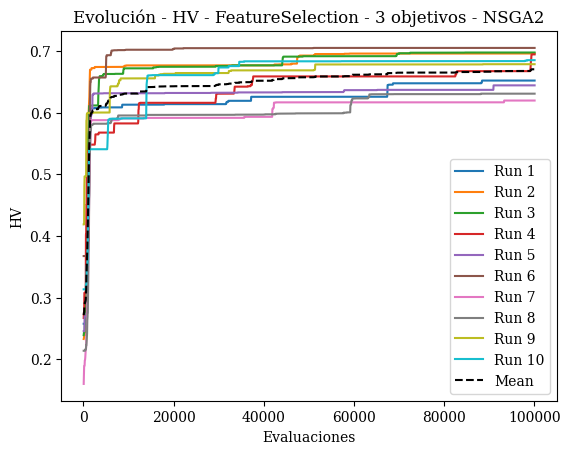

In [59]:
fig, ax = plt.subplots()
title = "Evolución - "+hv_indicator.__class__.__name__+" - "+problem.name()+" - "+str(problem.n_obj)+" objetivos - "+algorithm.__class__.__name__ 

ax.set_title(title)
plt.xlabel("Evaluaciones")
yTitle = hv_indicator.__class__.__name__
plt.ylabel(yTitle)

n_evals_mean = np.zeros((len(alg_callback.history),))
values_mean = np.zeros((len(alg_callback.history),))

for i, alg_callback in enumerate(alg_callbacks):
    ns_gen = np.array([e['gen'] for e in alg_callback.history])
    n_evals = pop_size*ns_gen
    values = np.array([e['hv'] for e in alg_callback.history])
    plt.plot(n_evals, values, label=f"Run {i+1}")
    
    n_evals_mean += n_evals
    values_mean += values
n_evals_mean = n_evals_mean/len(alg_callbacks)
values_mean = values_mean/len(alg_callbacks)
plt.plot(n_evals_mean, values_mean, label="Mean", color='black', linestyle='--')

plt.legend()
plt.show() 

En la gráfica podemos ver el hipervolumen de la población del MOEA a lo largo de las evaluaciones de la ejecución del algoritmo para cada una de las 10 semillas. Observamos los siguientes fenómenos:
* Estabilidad: todas las ejecuciones convergen a un valor de hipervolumen entre 0.6 y 0.7, y como hemos dicho antes la varianza del hipervolumen final es baja.
* Rápida convergencia: tras muy pocas evaluaciones el hipervolumen alcanza ya un valor medio de 0.6. A partir de ahí el hipervolumen aumenta muy lentamente. El hipervolumen medio (línea discontinua) se estabiliza en torno a las 80000 evaluaciones.
* Actualizaciones infrecuentes. Planteamos distintos motivos por los que sucede que el hipervolumen converge rápidamente y rara vez aumenta en las casi 2000 generaciones del algoritmo. Primero, la alta dimensionalidad hace que los individuos hijos sean muy diferentes a los padres, y por la mutación bit-flip (con probabilidad $p_m = \frac{50}{m}$) los individuos mutados también son muy diferentes a los originales. Después, por el carácter de los objetivos las soluciones no dominadas tienen entre 2 y 3 bits a 1 (atributos seleccionados), porque la correlación media con el target es máxima si escogemos los 2 atributos más correlacionados con el target, la correlación absoluta media entre features es mínima si escogemos los dos atributos más independientes y el tercer objetivo es directamente proporcional a la cardinalidad del subconjunto seleccionado. Todo esto hace que sea muy improbable que los individuos hijos sean mejores que los padres, y por tanto el hipervolumen rara vez aumenta. Este es el motivo por el que se cambió $p_m$ de 0.1 a $\frac{50}{m}$, para que los individuos mutados sean más similares a los originales y se mitigue este problema, pero aún así sucede por las características del problema.

In [60]:
scores_df.describe()

seed         HV         time        nds  RF_train_acc  \
count    10.00000  10.000000    10.000000  10.000000          10.0   
mean   2030.50000   0.670322  1053.397214  16.700000           1.0   
std       3.02765   0.030945    21.618509   4.295993           0.0   
min    2026.00000   0.619618  1019.634135   8.000000           1.0   
25%    2028.25000   0.646183  1038.614037  15.500000           1.0   
50%    2030.50000   0.681839  1049.936668  17.000000           1.0   
75%    2032.75000   0.695558  1070.154100  18.750000           1.0   
max    2035.00000   0.704978  1091.382078  23.000000           1.0   

       SVC_train_acc  MLP_train_acc  RF_test_acc  SVC_test_acc  MLP_test_acc  \
count      10.000000      10.000000    10.000000     10.000000     10.000000   
mean        0.965789       0.931579     0.773529      0.808824      0.732353   
std         0.032939       0.078654     0.133023      0.081142      0.149618   
min         0.894737       0.815789     0.441176      0.647059      0.470588   
25%         0.973684       0.861842     0.735294      0.794118      0.683824   
50%         0.973684       0.960526     0.794118      0.794118      0.720588   
75%         0.973684       1.000000     0.852941      0.838235      0.845588   
max         1.000000       1.000000     0.911765      0.941176      0.941176   

       ...  MLP_val_acc  RF_c_features  SVC_c_features  MLP_c_features  c_min  \
count  ...    10.000000      10.000000       10.000000       10.000000   10.0   
mean   ...     0.923750       2.500000        2.500000        2.500000    2.0   
std    ...     0.058055       0.527046        0.527046        0.527046    0.0   
min    ...     0.830556       2.000000        2.000000        2.000000    2.0   
25%    ...     0.881250       2.000000        2.000000        2.000000    2.0   
50%    ...     0.939583       2.500000        2.500000        2.500000    2.0   
75%    ...     0.967014       3.000000        3.000000        3.000000    2.0   
max    ...     1.000000       3.000000        3.000000        3.000000    2.0   

           c_max     f1_min     f1_max     f2_min     f2_max  
count  10.000000  10.000000  10.000000  10.000000  10.000000  
mean    3.400000  -0.730839  -0.412343   0.001204   0.583185  
std     0.516398   0.054671   0.084900   0.000911   0.124701  
min     3.000000  -0.819735  -0.553670   0.000072   0.400308  
25%     3.000000  -0.761118  -0.468772   0.000640   0.493109  
50%     3.000000  -0.744735  -0.432768   0.001081   0.571855  
75%     4.000000  -0.683421  -0.353382   0.001608   0.696165  
max     4.000000  -0.656248  -0.291871   0.003205   0.747379  

[8 rows x 22 columns]

### Comparación con el baseline

A continuación comparamos los resultados obtenidos con selección de atributos con el baseline (seleccionar todos los atributos).

In [79]:
# Analisis resultados
display(summary_df)
scores_all_df = pd.DataFrame(scores_all_dict)
display(summary_all_df)

HV         time  RF_train_acc  SVC_train_acc  MLP_train_acc  \
stat                                                                       
best   0.704978  1019.634135           1.0       1.000000       1.000000   
worst  0.619618  1091.382078           1.0       0.894737       0.815789   
mean   0.670322  1053.397214           1.0       0.965789       0.931579   
std    0.029357    20.509118           0.0       0.031248       0.074618   

       RF_test_acc  SVC_test_acc  MLP_test_acc  RF_c_features  SVC_c_features  \
stat                                                                            
best      0.911765      0.941176      0.941176            2.0             2.0   
worst     0.441176      0.647059      0.470588            3.0             3.0   
mean      0.773529      0.808824      0.732353            2.5             2.5   
std       0.126197      0.076978      0.141940            0.5             0.5   

       MLP_c_features  c_min     c_max    f1_min    f1_max    f2_min    f2_max  
stat                                                                            
best              2.0    2.0  3.000000 -0.819735 -0.553670  0.000072  0.400308  
worst             3.0    2.0  4.000000 -0.656248 -0.291871  0.003205  0.747379  
mean              2.5    2.0  3.400000 -0.730839 -0.412343  0.001204  0.583185  
std               0.5    0.0  0.489898  0.051866  0.080544  0.000864  0.118302

RF_train_acc  SVC_train_acc  MLP_train_acc  RF_test_acc  SVC_test_acc  \
stat                                                                           
best            1.0   8.157895e-01       1.000000     0.823529  6.176471e-01   
worst           1.0   8.157895e-01       0.921053     0.764706  6.176471e-01   
mean            1.0   8.157895e-01       0.981579     0.791176  6.176471e-01   
std             0.0   1.110223e-16       0.026447     0.020588  1.110223e-16   

       MLP_test_acc  
stat                 
best       0.941176  
worst      0.823529  
mean       0.882353  
std        0.034800

En la tabla de arriba se presenta el resumen estadístico de los resultados de la selección de atributos multiobjetivo, en la de abajo se presenta el resumen estadísco de los resultados del baseline (usar todos los atributos). Las medidas en train son muy altas en todos los modelos para ambos enfoques. Para las métricas de test observamos que:

* La mejor métrica de accuracy test mejora respecto al baseline en todos los modelos salvo MLP, que es exactamente igual. La coincidencia exacta no es tan extraña porque el dataset de test tiene solo 34 ejemplos.
* Sin embargo, la media de accuracy de test empeora en RF y MLP respecto al baseline.
* La varianza al usar la selección de atributos es mayor en todos los modelos.

Ahora podemos visualizar gráficamente las comparaciones:

In [80]:
# Gráfico de barras de RF, SVM, MLP test baseline frente a mean (sin superposición)
def plot_base_comp(metric="test_acc", 
                   title ="Test Accuracy", 
                   ylabel="Accuracy", 
                   df_comp=summary_df, 
                   df_base=summary_all_df, 
                   label_base="Mean Baseline", 
                   label_comp='Mean SA Multi-Objetivo',
                   stat='mean',
                   std=True):
        
    plt.figure(figsize=(10, 6))

    # Ancho de las barras
    bar_width = 0.4

    # Posiciones de las barras
    x = np.arange(len(estimator_names))
    
    # Barras para "mean"
    plt.bar(x - bar_width / 2, 
            df_comp.loc[stat, [f"{name}_{metric}" for name in estimator_names]], 
            label=label_comp, 
            yerr=df_comp.loc['std', [f"{name}_{metric}" for name in estimator_names]] if std else None, 
            width=bar_width)

    # Barras para "baseline"
    plt.bar(x + bar_width / 2, 
            df_base.loc[stat, [f"{name}_{metric}" for name in estimator_names]], 
            label=label_base,
            yerr=df_base.loc['std', [f"{name}_{metric}" for name in estimator_names]] if std else None,
            width=bar_width)

    # Etiquetas y formato
    plt.xticks(x, estimator_names)
    plt.xlabel('Estimadores')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

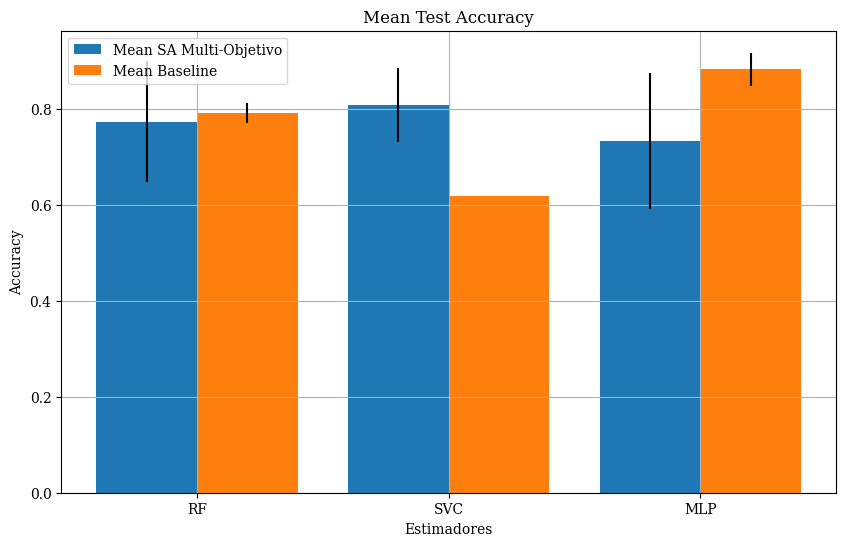

In [83]:
plot_base_comp(metric="test_acc", title ="Mean Test Accuracy", ylabel="Accuracy")

La accuracy en test media de los modelos de ML con selección de atributos es menor que la del baseline en MLP, mayor en SVC y un poco menor en RF. La varianza es mucho más alta al usar selección de atributos. Esto sucede porque la selección de atributos obtiene entre 2 y 3 atributos seleccionados como hemos visto antes y esto causa mucho overfitting pues el dataset es muy pequeño (38 instancias en train). Al usar todos los atributos, aunque muchos no sean relevantes o sean redundantes, el modelo es mucho más robusto al overfitting y consigue métricas en test más estables a la semilla inicial en MLP y RF.

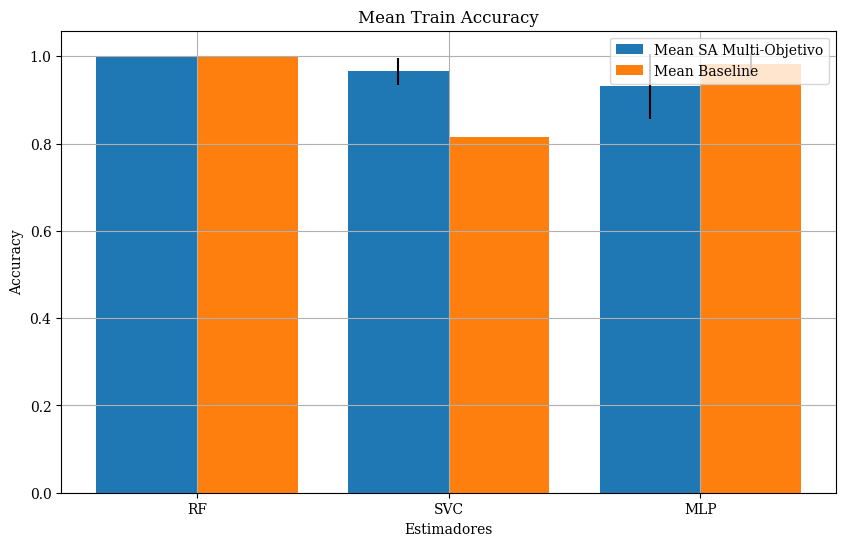

In [84]:
plot_base_comp(metric="train_acc", title ="Mean Train Accuracy", ylabel="Accuracy")

En cuanto al train accuracy, siempre es 1 para RF y cercano a 1 para MLP tanto en baseline como en selección de atributos. En SVC el accuracy en train es mayor al usar selección de atributos, sin que esto haya causado un mayor overfitting pues la métrica de test también era mayor. Esto puede ser debido a que al usar selección de atributos se ha eliminado ruido y redundancia, que causaban underfitting en el baseline para SVC.

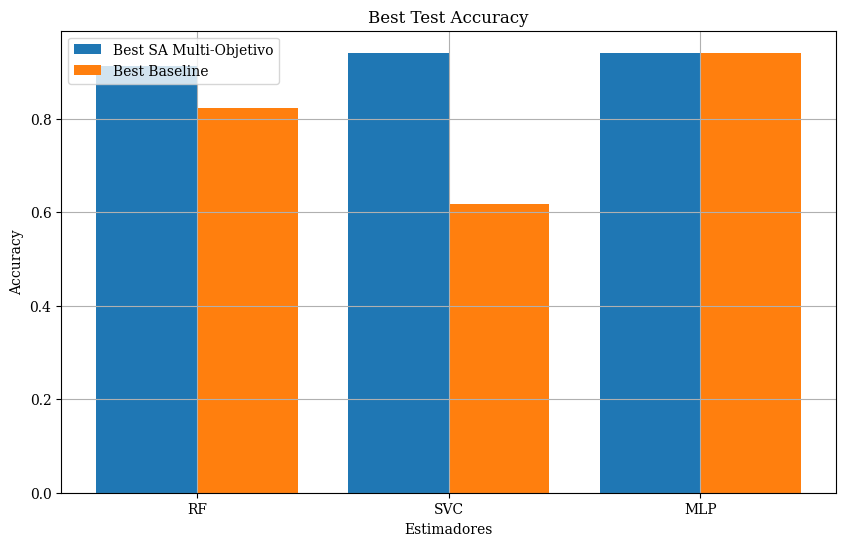

In [85]:
plot_base_comp(metric="test_acc", title ="Best Test Accuracy", ylabel="Accuracy", df_comp=summary_df, df_base=summary_all_df, label_base="Best Baseline", label_comp='Best SA Multi-Objetivo', stat='best', std=False)

En cuanto a las métricas de test en el mejor caso, mejoran respecto al baseline en RF y SVC, pero no en MLP que son exactamente iguales. Las métricas de test han sido peores de media pero mejores en el mejor caso. Esto recalca la importancia de ejecutar el algoritmo de selección de atributos multiobjetivo con distintas semillas para obtener mejores resultados. A continuación comparamos más fielmente los resultados usando test estadísticos.

In [ ]:
# test estadístico de comparación de medias
def compare_metrics(scores_df_comp, scores_df_baseline, comp_name, baseline_name, alpha=0.05):
    """
    Compara las métricas de test entre dos conjuntos de resultados (comp y baseline) usando pruebas estadísticas.

    Args:
        scores_df_comp (pd.DataFrame): DataFrame con las métricas del conjunto comparativo.
        scores_df_baseline (pd.DataFrame): DataFrame con las métricas del conjunto baseline.
        baseline_name (str): Nombre del conjunto baseline.
        comp_name (str): Nombre del conjunto comparativo.
        alpha (float): Nivel de significancia para las pruebas estadísticas.
    """
    for i, name in enumerate(estimator_names):
        # 1. Comprobar si las métricas de test siguen una distribución normal
        metric_name = f"{name}_test_acc"
        metric_values_comp = scores_df_comp[metric_name].to_numpy()
        metric_values_baseline = scores_df_baseline[metric_name].to_numpy()
        
        stat_comp, p_comp = shapiro(metric_values_comp)
        stat_baseline, p_baseline = shapiro(metric_values_baseline)
        
        print(f"Shapiro-Wilk test for {metric_name}")
        print(f"* {comp_name}: Statistics={stat_comp:.3f}, p-value={p_comp:.3f}")
        print(f"* {baseline_name}: Statistics={stat_baseline:.3f}, p-value={p_baseline:.3f}")
        
        if min(p_comp, p_baseline) > alpha:  # 2. Comparación de medias para atributos normales
            print(f"Sí Distribución normal para {metric_name}")
            # Comparar medias
            t_stat, p_value = ttest_rel(metric_values_baseline, metric_values_comp)
            print(f"T-test para {metric_name}: Estadística={t_stat:.3f}, p-valor={p_value:.3f}")
        else:  # 3. Comparación de medias para atributos no normales
            print(f"No Distribución normal para {metric_name}")
            # Ranking win-losses
            w_stat, p_value = wilcoxon(metric_values_baseline, metric_values_comp)
            print(f"Wilcoxon test para {metric_name}: Estadística={w_stat:.3f}, p-valor={p_value:.3f}")
        
        # Evaluar hipótesis nula
        if p_value < alpha:
            print(f"Diferencia significativa entre {baseline_name} y {comp_name}")
            if scores_df_baseline[metric_name].mean() > scores_df_comp[metric_name].mean():
                print(f"{comp_name} peor que {baseline_name}: {scores_df_comp[metric_name].mean():.4f} < {scores_df_baseline[metric_name].mean():.4f}")
            else:
                print(f"{comp_name} mejor que {baseline_name}: {scores_df_comp[metric_name].mean():.4f} > {scores_df_baseline[metric_name].mean():.4f}")
        else:
            print(f"No hay diferencia significativa entre {baseline_name} y {comp_name}")
            print(f"Medias {baseline_name} y {comp_name}: {scores_df_baseline[metric_name].mean():.4f} ~ {scores_df_comp[metric_name].mean():.4f}")
        
        print("----")

compare_metrics(scores_df, scores_all_df, "SAMO", "Baseline")

Shapiro-Wilk test for RF_test_acc
* SAMO: Statistics=0.805, p-value=0.017
* Baseline: Statistics=0.833, p-value=0.036
No Distribución normal para RF_test_acc
Wilcoxon test para RF_test_acc: Estadística=20.000, p-valor=0.767
No hay diferencia significativa entre Baseline y SAMO
Medias Baseline y SAMO: 0.7912 ~ 0.7735
----
Shapiro-Wilk test for SVC_test_acc
* SAMO: Statistics=0.891, p-value=0.172
* Baseline: Statistics=1.000, p-value=1.000
Sí Distribución normal para SVC_test_acc
T-test para SVC_test_acc: Estadística=-7.451, p-valor=0.000
Diferencia significativa entre Baseline y SAMO
SAMO mejor que Baseline: 0.8088 > 0.6176
----
Shapiro-Wilk test for MLP_test_acc
* SAMO: Statistics=0.939, p-value=0.545
* Baseline: Statistics=0.940, p-value=0.550
Sí Distribución normal para MLP_test_acc
T-test para MLP_test_acc: Estadística=3.104, p-valor=0.013
Diferencia significativa entre Baseline y SAMO
SAMO peor que Baseline: 0.7324 < 0.8824
----


Se han realizado test estadísticos para comparar la accuracy media en test de los modelos de ML con selección de atributos y del baseline. Los test que se han realizado son:
* Test de Shapiro-Wilk: para comprobar si hay o no normalidad de los datos para cada modelo y tipo de selección: multiobjetivo (SAMO) o baseline.
* En caso de que para un mismo modelo, las métricas de SAMO y baseline sigan una distribución normal, se realiza el test t de Student, que compara las medias de dos muestras independientes. La hipótesis nula es que las dos muestras tienen la misma media.
* En caso de que no sigan una distribución normal, se realiza el test de Wilcoxon, que compara las medianas de dos muestras independientes. La hipótesis nula vuelve a ser que las dos muestras tienen la misma media, pero el test no asume normalidad.
  
El valor de significancia escogido es $\alpha = 0.05$. En el caso de que la hipótesis nula se rechace, se concluye que las dos muestras tienen medias diferentes. En el caso de que no se rechace, no podemos concluir que las dos muestras tengan medias diferentes, y decimos que no hay diferencias significativas entre las muestras comparadas. Los resultados obtenidos son:

* No hay diferencia significativa entre la accuracy media en test de SAMO y baseline para RF.
* Sí la hay para SVC y MLP, donde:
  * Para SVC, la media de la accuracy en test de SAMO es significativamente mayor que la del baseline.
  * Para MLP, la media de la accuracy en test de SAMO es significativamente menor que la del baseline.

### Comparación con selección de atributos por ranking

Según las diapositivas de clase "los métodos de evaluación de subconjuntos de atributos se usan cuando el
número de atributos no es excesivamente elevado. En caso contrario (p.e., gene
expression data) es más práctico usar métodos de feature ranking" (Jiménez et. al, 2022). En nuestro caso el número de atributos es 7129 y además el dataset ALL-AML es de expresión de genes, así que estaríamos en un caso de aplicación más apropiado para feature ranking que para selección de atributos multiobjetivo, que es un caso particular de método de evaluación de subconjuntos de atributos. Por eso hemos decidido comparar el rendimiento del MOEA para selección de atributos con un método de feature ranking de *sklearn*. Hemos utilizado el método *SelectKBest* con la medida *f_classif*, que es el ANOVA F-value entre el atributo y el target. Esta función mide cómo de bien un atributo discrimina entre las distintas clases del target.

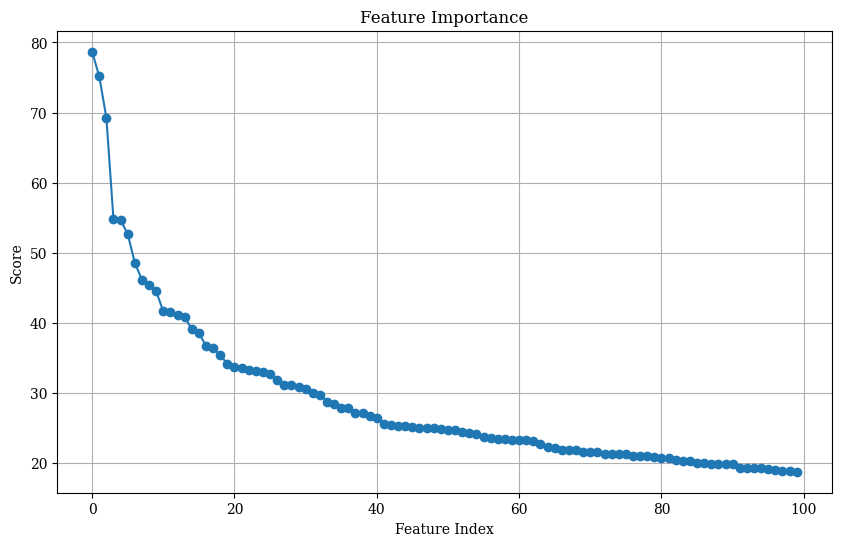

In [86]:
## Test con selección de atributos por ranking
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_train, y_train)

scores= selector.scores_
top_k = 100
top_indices = np.argsort(scores)[::-1][:top_k]

# plot para regla del codo
plt.figure(figsize=(10, 6))
plt.plot(range(top_k), scores[top_indices], marker='o')
plt.title('Feature Importance')
plt.xlabel('Feature Index')
plt.ylabel('Score')
plt.grid(True)
plt.show()


Por la regla del codo hemos decidido usar 20 atributos seleccionados. Evaluamos esta nueva solución sobre los 3 modelos para 10 semillas distintas.

In [89]:
# seleccionamos los 20 mejores atributos
k_features = 20
selected_features = top_indices[:20]
scores_rank_dict = {col: [] for col in columns}

if not DONE:
    for t in range(1,11):
        seed = SEED + t
        estimators = getEstimators(random_state=seed)
        train_scores = []
        test_scores = []
        val_scores = []
        c_features = []
        
        print(f"Ejecutando prueba {t} de 10")
        print("Semilla: ", seed)
        
        for estimator in estimators:
            print(f"Entrenando clasificador: {estimator.__class__.__name__}")
            X = selector.transform(X_train)[:, selected_features]
            estimator.fit(X , y_train)
            
            train_accuracy = estimator.score(X , y_train)
            test_accuracy = estimator.score(selector.transform(X_test)[:, selected_features], y_test)
            
            
            train_scores.append(train_accuracy)
            test_scores.append(test_accuracy)
            
            # K-fold CV Validation accuracy
            
            val_accuracy = cross_val_score(estimator, X, y_train, cv=cv)
            mean_val_accuracy = np.mean(val_accuracy)
            val_scores.append(mean_val_accuracy)
            
            print(f"Validation accuracy: {mean_val_accuracy}")
            print(f"Train accuracy: {train_accuracy}")
            print(f"Test accuracy: {test_accuracy}")


        hv = 0
                
        n_nds = 1
        c_features = [k_features] * len(estimator_names)
        c_min = k_features
        c_max = k_features
        selected_individual = np.zeros(n_features)
        selected_individual[selected_features] = 1
        f1_min = -1*problem.f1(selected_individual, k_features)
        f1_max = f1_min
        f2_min = problem.f2(selected_individual, k_features)
        f2_max = f2_min
        
        # Agregar resultados al diccionario
        scores_rank_dict = add_results_to_dict(scores_rank_dict, seed, hv, 0, n_nds, train_scores, test_scores, val_scores,
                                            c_features, c_min, c_max, f1_min, f1_max, f2_min, f2_max)
        print("----------------------")

Ejecutando prueba 1 de 10
Semilla:  2026
Entrenando clasificador: RandomForestClassifier
Validation accuracy: 0.9583333333333333
Train accuracy: 1.0
Test accuracy: 0.8823529411764706
Entrenando clasificador: SVC
Validation accuracy: 0.9597222222222221
Train accuracy: 0.9736842105263158
Test accuracy: 0.9705882352941176
Entrenando clasificador: MLPClassifier
Validation accuracy: 0.7777777777777778
Train accuracy: 0.7894736842105263
Test accuracy: 0.7941176470588235
----------------------
Ejecutando prueba 2 de 10
Semilla:  2027
Entrenando clasificador: RandomForestClassifier
Validation accuracy: 0.9722222222222222
Train accuracy: 1.0
Test accuracy: 0.9117647058823529
Entrenando clasificador: SVC
Validation accuracy: 0.9597222222222221
Train accuracy: 0.9736842105263158
Test accuracy: 0.9705882352941176
Entrenando clasificador: MLPClassifier
Validation accuracy: 0.9083333333333333
Train accuracy: 1.0
Test accuracy: 0.9411764705882353
----------------------
Ejecutando prueba 3 de 10
Semil

In [91]:
path_csv_scores_rank = os.path.join(RESULTS_DIR, "scores-rank.csv")

if not LOAD:
    df = pd.DataFrame(scores_rank_dict)

    if not os.path.exists(RESULTS_DIR):
        os.makedirs(RESULTS_DIR)
        
    df.to_csv(path_csv_scores_rank, index=False)
else:
    scores_rank_df = pd.read_csv(path_csv_scores_rank)
    scores_rank_dict = scores_rank_df.to_dict(orient='list')

In [92]:
scores_rank_df = pd.DataFrame(scores_rank_dict)
display(scores_rank_df)

seed  HV  time  nds  RF_train_acc  SVC_train_acc  MLP_train_acc  \
0  2026   0     0    1           1.0       0.973684       0.789474   
1  2027   0     0    1           1.0       0.973684       1.000000   
2  2028   0     0    1           1.0       0.973684       0.973684   
3  2029   0     0    1           1.0       0.973684       1.000000   
4  2030   0     0    1           1.0       0.973684       1.000000   
5  2031   0     0    1           1.0       0.973684       1.000000   
6  2032   0     0    1           1.0       0.973684       1.000000   
7  2033   0     0    1           1.0       0.973684       0.973684   
8  2034   0     0    1           1.0       0.973684       0.394737   
9  2035   0     0    1           1.0       0.973684       0.552632   

   RF_test_acc  SVC_test_acc  MLP_test_acc  ...  MLP_val_acc  RF_c_features  \
0     0.882353      0.970588      0.794118  ...     0.777778             20   
1     0.911765      0.970588      0.941176  ...     0.908333             20   
2     0.882353      0.970588      0.823529  ...     0.775000             20   
3     0.882353      0.970588      0.794118  ...     0.868056             20   
4     0.882353      0.970588      0.911765  ...     0.866667             20   
5     0.882353      0.970588      0.941176  ...     0.905556             20   
6     0.911765      0.970588      0.882353  ...     0.881944             20   
7     0.852941      0.970588      0.911765  ...     0.881944             20   
8     0.852941      0.970588      0.411765  ...     0.379167             20   
9     0.882353      0.970588      0.529412  ...     0.684722             20   

   SVC_c_features  MLP_c_features  c_min  c_max    f1_min    f1_max    f2_min  \
0              20              20     20     20 -0.748469 -0.748469  0.648342   
1              20              20     20     20 -0.748469 -0.748469  0.648342   
2              20              20     20     20 -0.748469 -0.748469  0.648342   
3              20              20     20     20 -0.748469 -0.748469  0.648342   
4              20              20     20     20 -0.748469 -0.748469  0.648342   
5              20              20     20     20 -0.748469 -0.748469  0.648342   
6              20              20     20     20 -0.748469 -0.748469  0.648342   
7              20              20     20     20 -0.748469 -0.748469  0.648342   
8              20              20     20     20 -0.748469 -0.748469  0.648342   
9              20              20     20     20 -0.748469 -0.748469  0.648342   

     f2_max  
0  0.648342  
1  0.648342  
2  0.648342  
3  0.648342  
4  0.648342  
5  0.648342  
6  0.648342  
7  0.648342  
8  0.648342  
9  0.648342  

[10 rows x 22 columns]

En esta tabla se presentan los resultados de la selección de atributos por ranking para cada semilla y cada modelo. Las métricas obtenidas son las mismas que para el baseline. Observamos que los valores de *f

A continuación presentamos el resumen estadístico de las métricas de accuracy.

In [93]:
# Reportar tabla con columnas: seed, hv, time, rf_train_acc, rf_test_acc, svc_train_acc, svc_test_acc, mlp_train_acc, mlp_test_acc
# añadir filas adicionales: mejor, peor, media y desviación típica

# Crear un nuevo DataFrame con los resultados
summary_rank_dict = {}
summary_rank_dict['seed'] = ['best', 'worst', 'mean', 'std']
estimator_names = ['RF', 'SVC', 'MLP']

for metric in ['train_acc', 'test_acc']:
    for i, name in enumerate(estimator_names):
        metric_name = f"{name}_{metric}"
        metric_values = scores_rank_df[metric_name].to_numpy()
        if metric != 'c_features':
            summary_rank_dict[metric_name] = [np.max(metric_values), np.min(metric_values), np.mean(metric_values), np.std(metric_values)]
        else:
            summary_rank_dict[metric_name] = [np.min(metric_values), np.max(metric_values), np.mean(metric_values), np.std(metric_values)]

summary_rank_df = pd.DataFrame(summary_rank_dict)
summary_rank_df = summary_rank_df.set_index('seed')
# renombrar columna seed a stat
summary_rank_df = summary_rank_df.rename_axis('stat')

display(summary_rank_df)

RF_train_acc  SVC_train_acc  MLP_train_acc  RF_test_acc  SVC_test_acc  \
stat                                                                           
best            1.0   9.736842e-01       1.000000     0.911765  9.705882e-01   
worst           1.0   9.736842e-01       0.394737     0.852941  9.705882e-01   
mean            1.0   9.736842e-01       0.868421     0.882353  9.705882e-01   
std             0.0   1.110223e-16       0.209537     0.018602  1.110223e-16   

       MLP_test_acc  
stat                 
best       0.941176  
worst      0.411765  
mean       0.794118  
std        0.172002

En la tabla

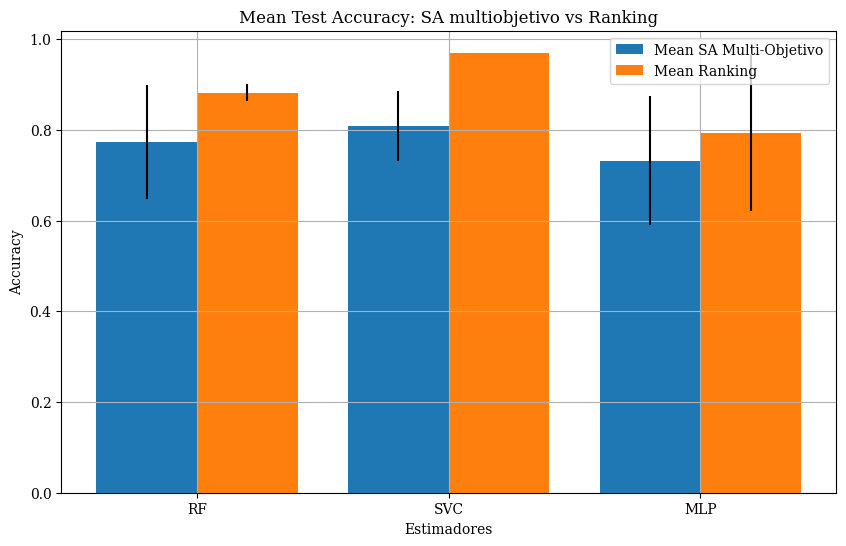

In [96]:
# grafico de barras de RF, SVM, MLP test ranking frente a mean (sin superposición)

plot_base_comp(metric="test_acc", title ="Mean Test Accuracy: SA multiobjetivo vs Ranking", ylabel="Accuracy", df_comp=summary_df, df_base=summary_rank_df, label_base="Mean Ranking")

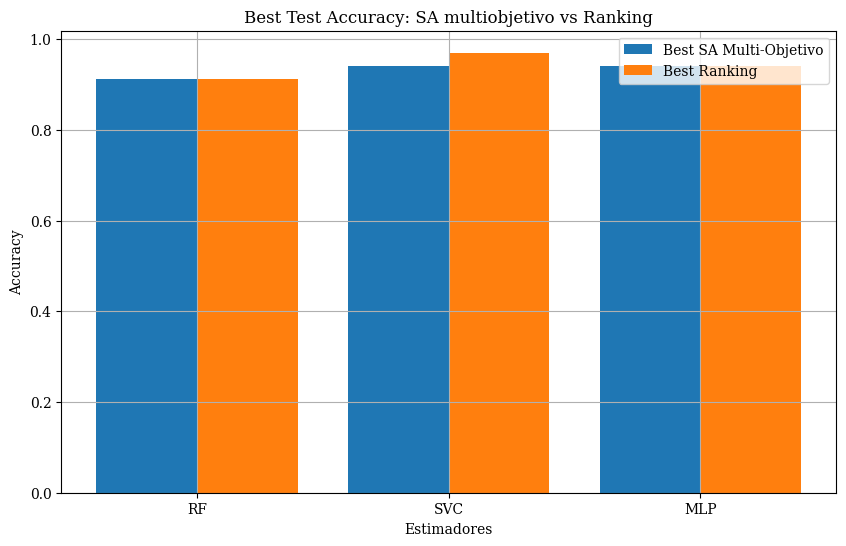

In [105]:
plot_base_comp(metric="test_acc", title ="Best Test Accuracy: SA multiobjetivo vs Ranking", ylabel="Accuracy", df_comp=summary_df, df_base=summary_rank_df, label_comp="Best SA Multi-Objetivo", label_base="Best Ranking", stat='best', std=False)

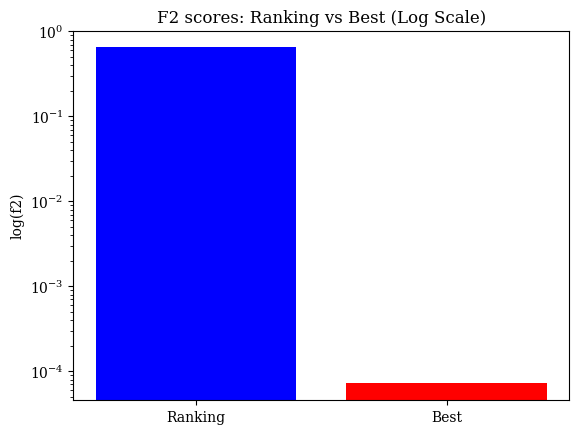

f2 ranking: 0.6483423923558473, f2 best: 7.183307893570745e-05


In [97]:
f2_ranking = scores_rank_df.loc[0, 'f2_min']
f2_mean = summary_df.loc['best', 'f2_min']

plt.title("F2 scores: Ranking vs Best (Log Scale)")
plt.bar(['Ranking', 'Best'], [f2_ranking, f2_mean], color=['blue', 'red'])
plt.yscale('log')  # Cambiar la escala del eje Y a logarítmica
plt.ylabel("log(f2)")
plt.show()

print(f"f2 ranking: {f2_ranking}, f2 best: {f2_mean}")

f1 ranking: 0.7484693525603311, f1 best: 0.8197347498969264


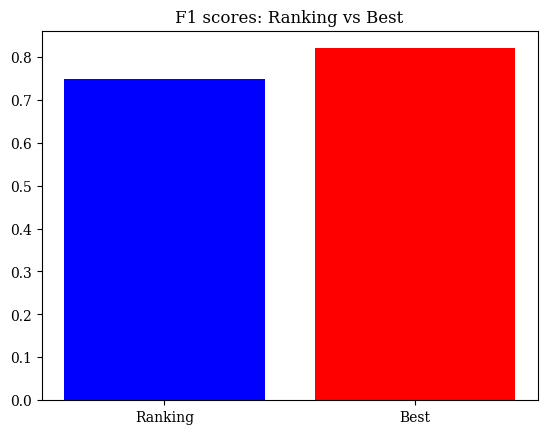

In [98]:
f1_ranking = -1*scores_rank_df.loc[0, 'f1_min']
f1_mean = -1*summary_df.loc['best', 'f1_min']
plt.title("F1 scores: Ranking vs Best")
plt.bar(['Ranking', 'Best'], [f1_ranking, f1_mean], color=['blue', 'red'])
print(f"f1 ranking: {f1_ranking}, f1 best: {f1_mean}")

In [103]:
compare_metrics(scores_rank_df, scores_df, "Ranking", "SAMO")

Shapiro-Wilk test for RF_test_acc
* Ranking: Statistics=0.815, p-value=0.022
* SAMO: Statistics=0.805, p-value=0.017
No Distribución normal para RF_test_acc
Wilcoxon test para RF_test_acc: Estadística=1.500, p-valor=0.004
Diferencia significativa entre SAMO y Ranking
Ranking mejor que SAMO: 0.8824 > 0.7735
----
Shapiro-Wilk test for SVC_test_acc
* Ranking: Statistics=1.000, p-value=1.000
* SAMO: Statistics=0.891, p-value=0.172
Sí Distribución normal para SVC_test_acc
T-test para SVC_test_acc: Estadística=-6.304, p-valor=0.000
Diferencia significativa entre SAMO y Ranking
Ranking mejor que SAMO: 0.9706 > 0.8088
----
Shapiro-Wilk test for MLP_test_acc
* Ranking: Statistics=0.783, p-value=0.009
* SAMO: Statistics=0.939, p-value=0.545
No Distribución normal para MLP_test_acc
Wilcoxon test para MLP_test_acc: Estadística=18.500, p-valor=0.375
No hay diferencia significativa entre SAMO y Ranking
Medias SAMO y Ranking: 0.7324 ~ 0.7941
----


## 7. Conclusiones


## Referencias

1. Jiménez Barrionuevo, F., & Sánchez Carpena, G. (2025). Computación Bio-inspirada. Tema 5: Algoritmos bio-inspirados para machine learning. Máster en Inteligencia Artificial, Universidad de Murcia. Departamento de Ingeniería de la Información y las Comunicaciones. Disponible en: https://aulavirtual.um.es/access/content/group/7933_P_2024_N_N/2.%20Diapositivas%20de%20clase/Tema5.pdf
2. pymoo documentation. pymoo: Multi-objective Optimization in Python. Disponible en: https://pymoo.org (Accedido el 21 de abril de 2025).
3. Hall, M. A. (1999). Correlation-based feature selection for discrete and numeric class machine learning. In Proceedings of the 17th International Conference on Machine Learning (ICML-2000) (pp. 359-366). Morgan Kaufmann. Disponible en https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=0e78b20b27d27261f9ae088eb13201f2d5b185bd (Accedido el 21 de abril de 2025).
4. Selección de atributos evolutiva multi-objetivo para clasificación (pymoo), Jupyter Notebook.
Fernando Jiménez Barrionuevo y Gracia Sánchez Carpena. Notebook 16 de clase de Computación Bio-inspirada, Máster en Inteligencia Artificial, Universidad de Murcia, 2025.
Disponible en: https://aulavirtual.um.es/access/content/group/7933_P_2024_N_N/2.%20PRÁCTICAS/ipynb/Selección%20de%20atributos%20evolutiva%20multi-objetivo%20para%20clasificación%20_pymoo_.ipynb​
5. Algoritmo evolutivo multi-many-objective (pymoo), Jupyter Notebook.
Fernando Jiménez Barrionuevo y Gracia Sánchez Carpena. Notebook 9 de clase de Computación Bio-inspirada, Máster en Inteligencia Artificial, Universidad de Murcia, 2025.
Disponible en: https://aulavirtual.um.es/access/content/group/7933_P_2024_N_N/2.%20PRÁCTICAS/ipynb/Algoritmo%20evolutivo%20multi-many-objective%20_pymoo_.ipynb
6. F. Jiménez, G. Sánchez, J. Palma, L. Miralles-Pechuán, and J. A. Botía.
Multivariate feature ranking with high-dimensional data for classification
tasks. IEEE Access, 10:60421–60437, 2022

## Contribución de cada miembro del grupo

- Santiago Méndez García:
 
- Domingo Méndez García: 
  - Presentación oral.